In [140]:
fname = '/mnt/archive/Antonio/data/manta/smdata/2017-05-23/04_22d_inplace.hdf5'
plot_timetraces = True
and_gate_size_sel_kws = dict(th1=20, gamma=0.5, add_aex=True)
and_gate_min_rate_cps = 30e3

In [2]:
from pathlib import Path

In [3]:
fname = Path(fname)

In [4]:
mlabel = '{}_{}'.format(fname.parts[-2], fname.stem[:6])
mlabel

'2017-05-23_04_22d'

In [5]:
assert fname.is_file(), 'File not found.'

# Imports

In [6]:
import os
from pathlib import Path
import numpy as np
from IPython.display import display, HTML
import pandas as pd
import matplotlib as mpl
mpl.rcParams['font.sans-serif'].insert(0, 'Arial')
%matplotlib inline
import matplotlib.pyplot as plt
from heatmap import heatmap48, spotsh, spotsv
import pybroom as br

In [125]:
plt.rcParams['font.size'] = 14

In [7]:
%config InlineBackend.figure_format = 'retina'

In [8]:
from fretbursts import *

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
--------------------------------------------------------------
 You are running FRETBursts (version 0.6.3+89.g6d42c7c).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


In [9]:
sns = init_notebook(apionly=True)

In [10]:
pd.options.display.max_columns = 48
pd.options.display.max_rows = 48

def make_df_bursts(list_of_columns):
    ncols = 48
    assert len(list_of_columns) == ncols
    nrows = max(len(x) for x in list_of_columns)
    columns = np.arange(ncols)
    df = pd.DataFrame(columns=columns, index=np.arange(nrows), dtype=float)
    df.columns.name = 'spot'
    for col, col_data in zip(columns, list_of_columns):
        df.iloc[:len(col_data), col] = col_data
    return df

def make_df_spots(list_of_tuples=None):
    nrows = 48
    df = pd.DataFrame(index=np.arange(nrows))
    if list_of_tuples is None:
        list_of_tuples = []
    for col, col_data in list_of_tuples:
        df[col] = col_data
    return df

In [11]:
def cal_phrate(d, stream, phrates=None, recompute=False):
    if phrates is None:
        phrates = {}
    phrates_fname = Path('results/%s_phrate_%s.csv' % (mlabel, stream))
    phrates_fnameB = Path('results/%s_phrate_%sB.csv' % (mlabel, stream))
    if phrates_fname.is_file() and not recompute:
        phrates[str(stream)] = pd.read_csv(phrates_fname, index_col=0)
        phrates[str(stream)].index.name = 'spot'
        phr = pd.read_csv(phrates_fnameB, index_col=0)
        phr.columns = [int(c) for c in phr.columns]
        phr.columns.name = 'spot'
        phrates[str(stream)+'B'] = phr
    else:
        try:
            d.calc_max_rate(m=10, ph_sel=stream, compact=True)
        except ValueError:
            d.calc_max_rate(m=10, ph_sel=stream, compact=False)
        phrates[str(stream)+'B'] = make_df_bursts(d.max_rate)
        phrates[str(stream)] = (make_df_spots()
                        .assign(**{'num_bursts': d.num_bursts})
                        .assign(**{'num_nans': [np.isnan(x).sum() for x in d.max_rate]})
                        .assign(**{'num_valid': lambda x: x.num_bursts - x.num_nans})
                        .assign(**{'valid_fraction': lambda x: 100 * x.num_valid / x.num_bursts})
                      )
        phrates[str(stream)].to_csv(phrates_fname)
        phrates[str(stream)+'B'].to_csv(phrates_fnameB)

    print('   Valid fraction (mean of all ch): %.1f %%' %
          phrates[str(stream)].valid_fraction.mean())
    return phrates

In [12]:
def info_html(d):
    Dex, Aex = d.setup['excitation_input_powers']*1e3
    s = """
    <h3>File: &nbsp; &nbsp; &nbsp; {fname}</h3>
    <blockquote><p class="lead">{descr}</p></blockquote>
    <ul>
    <li><span style='display: inline-block; width: 150px;'>Acquisition duration:</span> {time:.1f} s </li>
    <li><span style='display: inline-block; width: 150px;'>Laser power:</span>  <b>{Dex:.0f}mW</b> @ 532nm &nbsp;&nbsp;&nbsp;  
                                                                                <b>{Aex:.0f}mW</b> @ 628nm </li>
    <li><span style='display: inline-block; width: 150px;'>ALEX period [offset]: </span> {period} ({period_us:.1f} μs)  [{offset}] </li></ul>
    """.format(fname=fname, time=float(d.acquisition_duration), Dex=Dex, Aex=Aex, 
               period=d.alex_period, period_us=d.alex_period*d.clk_p*1e6, offset=d.offset,
               descr=d.description.decode())
    return HTML(s)

In [141]:
save_figures = True
savefigdir_ = 'figures'

def save_name(name, folder='.', nospaces=False):
    sname = '%s/%s_%s' % (folder, mlabel, name)
    if nospaces:
        sname = sname.replace(' ', '_')
    return sname 
    
def savefig(name, nospaces=True, **kwargs):
    if not save_figures:
        return
    kwargs_ = dict(dpi=100, bbox_inches='tight')
                   #frameon=True, facecolor='white', transparent=False)
    kwargs_.update(kwargs)
    fname = save_name(name, savefigdir_, nospaces=nospaces)
    plt.savefig(fname, **kwargs_)
    print('Saved: %s.png' % fname, flush=True)

# Load Data

In [14]:
d = loader.photon_hdf5(str(fname), ondisk=True)

In [15]:
info_html(d)

In [16]:
d.add(A_ON=(100, 1950), D_ON=(2150, 4000), offset=3550, alex_period=4000)

AttributeError: 'Data' object has no attribute 'ph_times_t'

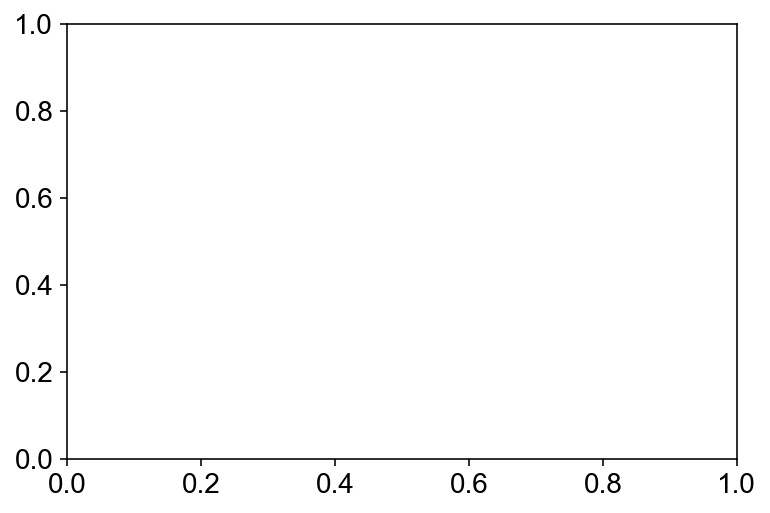

In [126]:
bpl.plot_alternation_hist(d)

In [ ]:
%%timeit -n1 -r1 
loader.alex_apply_period(d)

In [ ]:
dcr_fname = 'DCR_N2Top_N5Bott.csv'
dcr = pd.read_csv(dcr_fname, index_col=0)
dcr.head()

# Analysis

## Timetraces

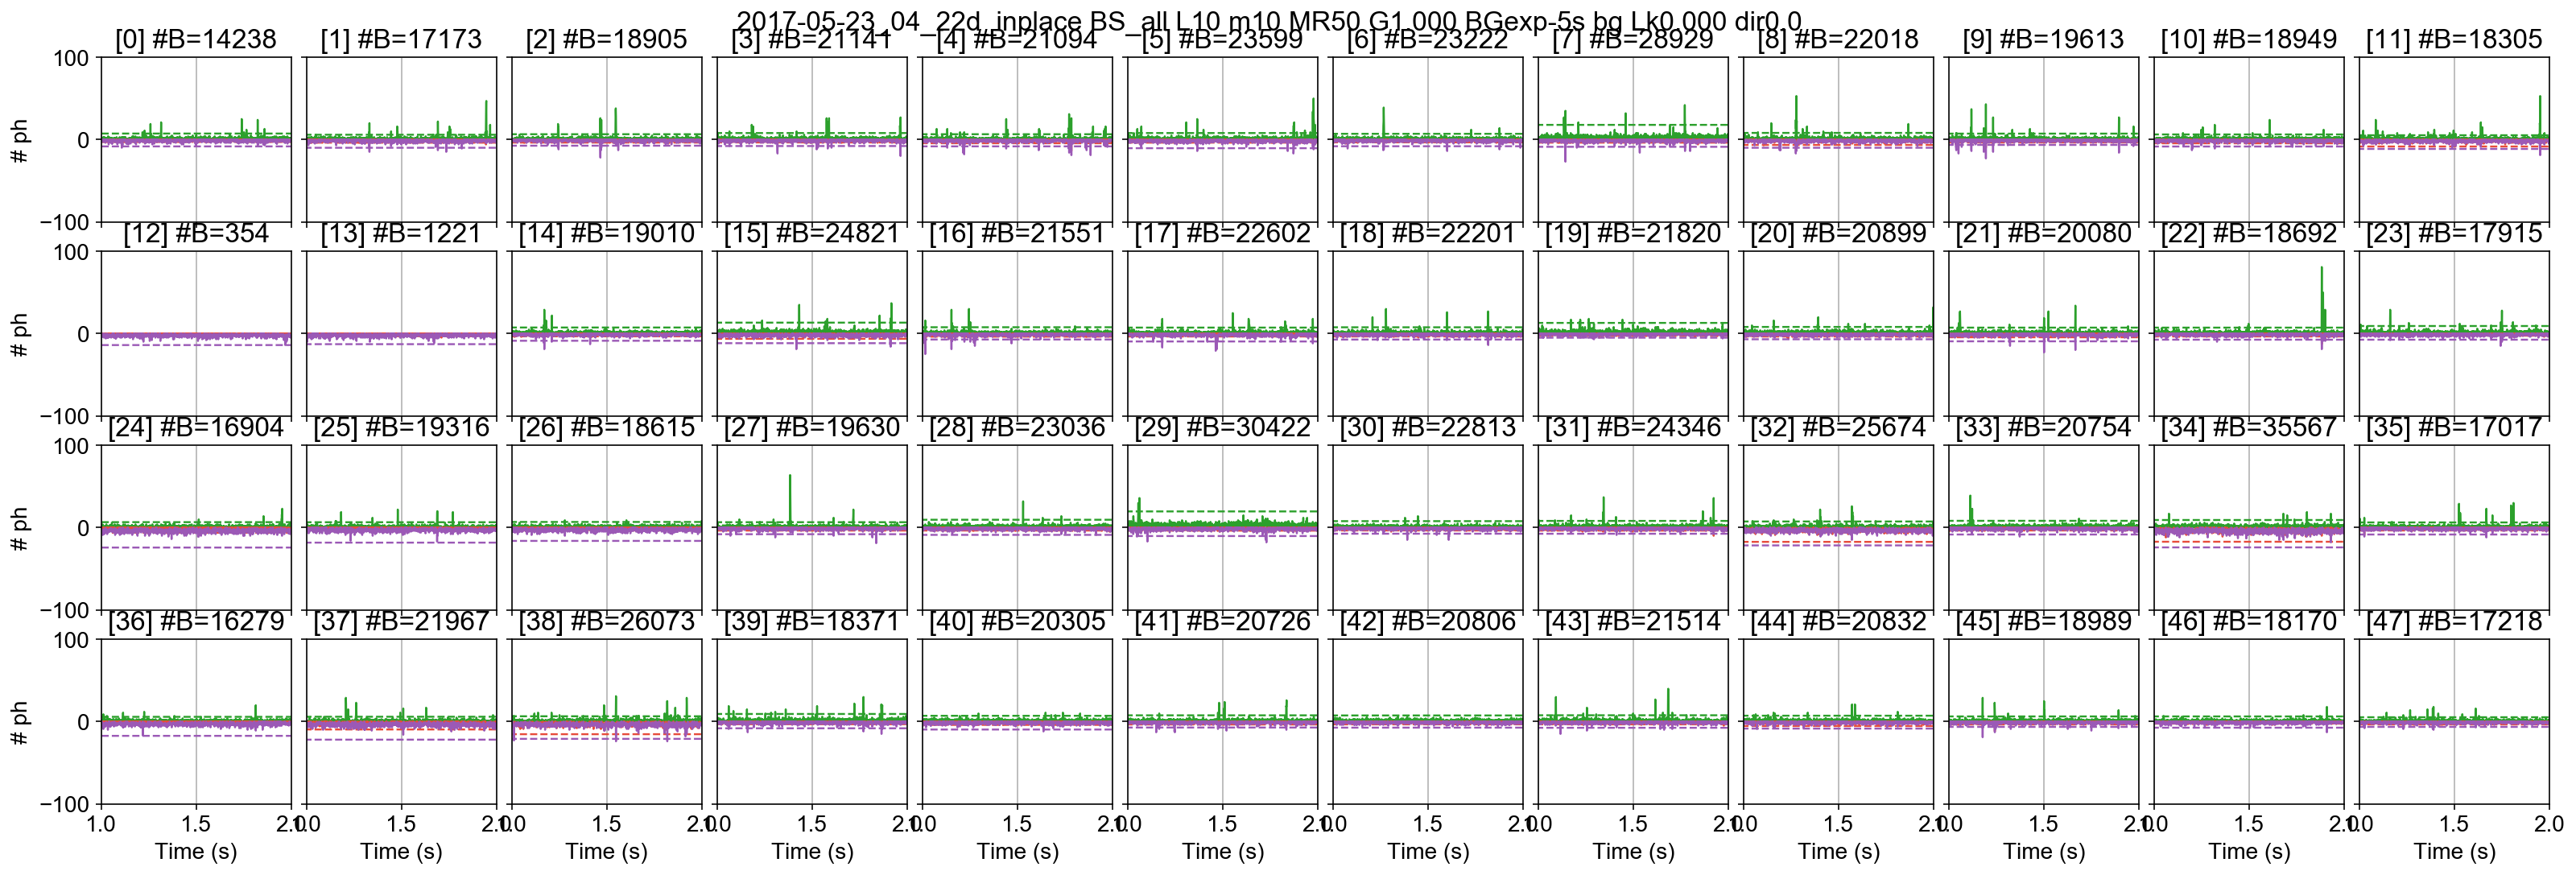

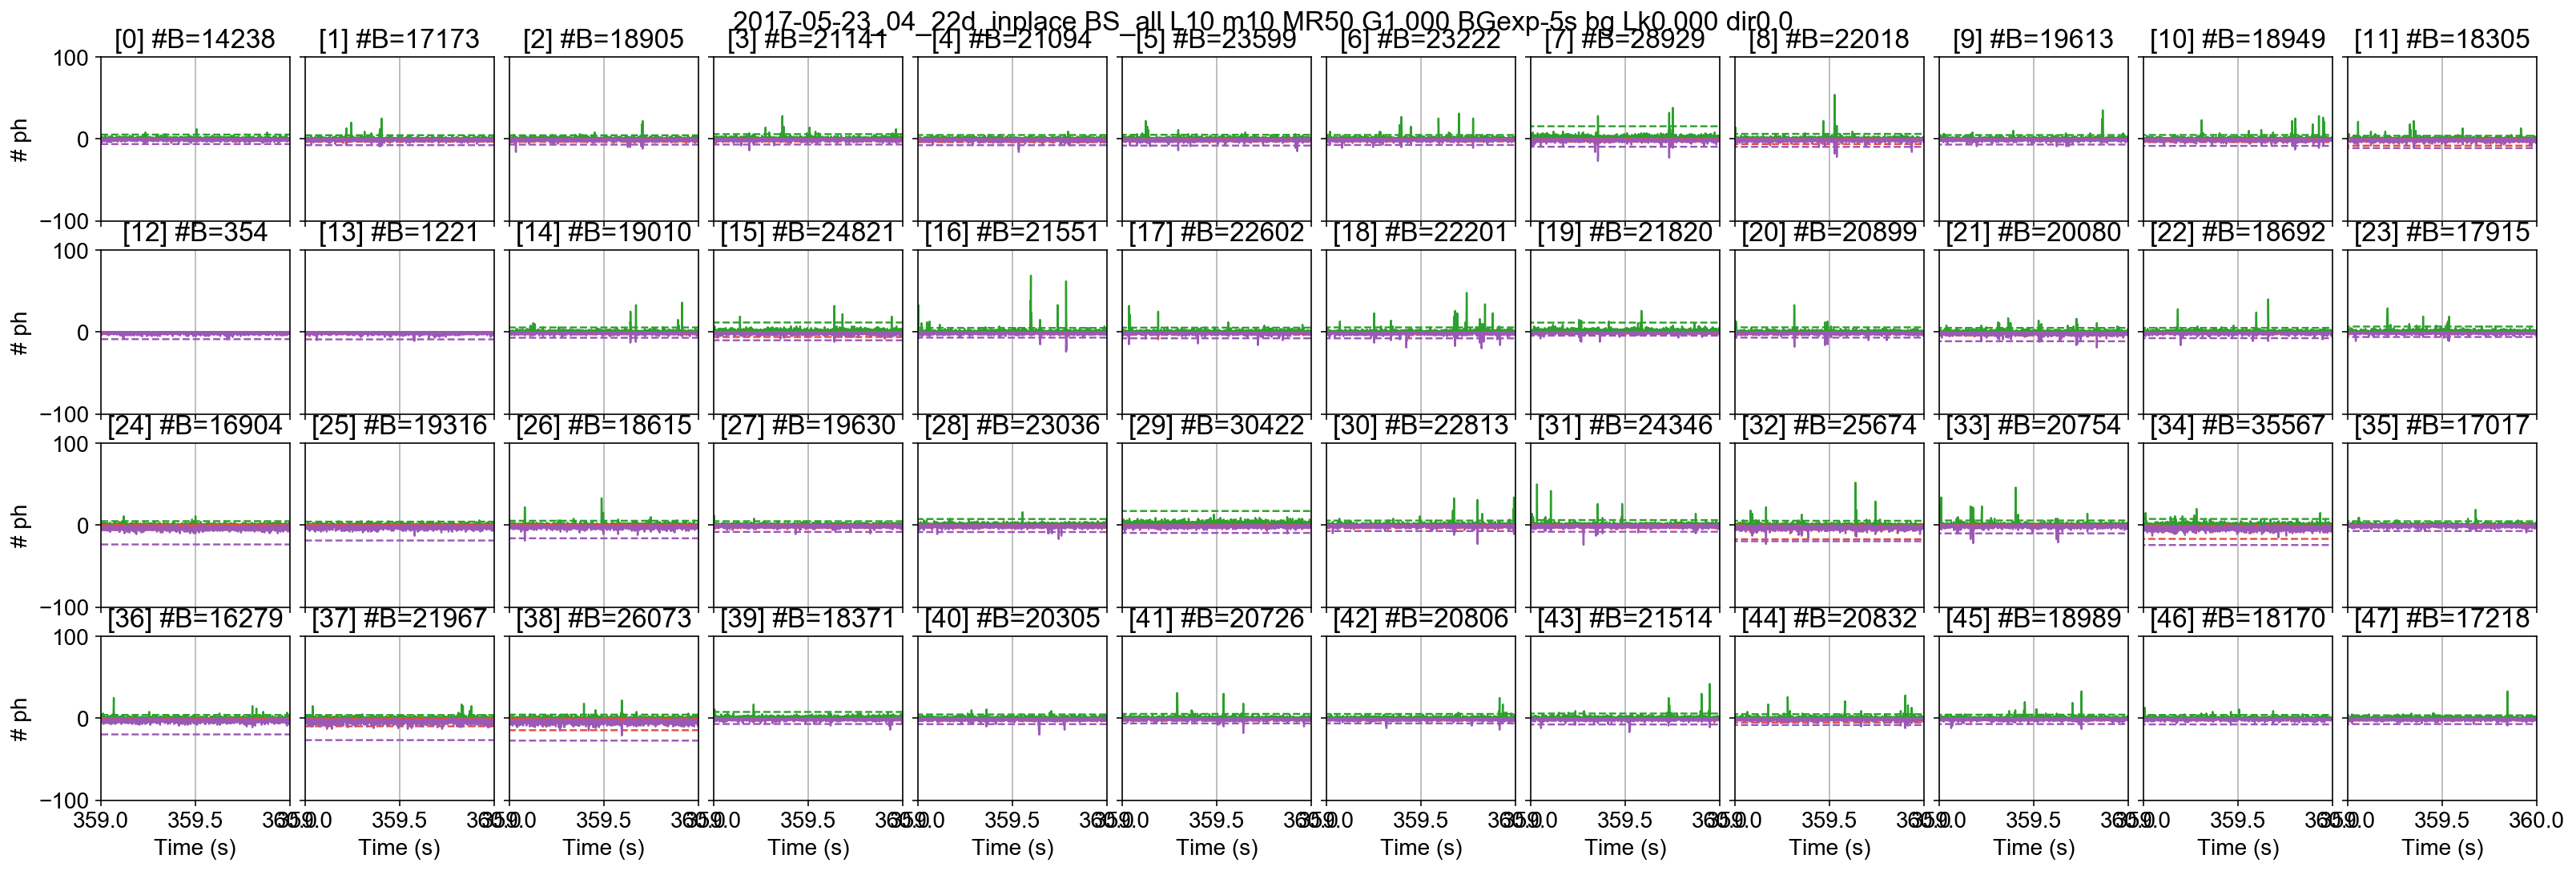

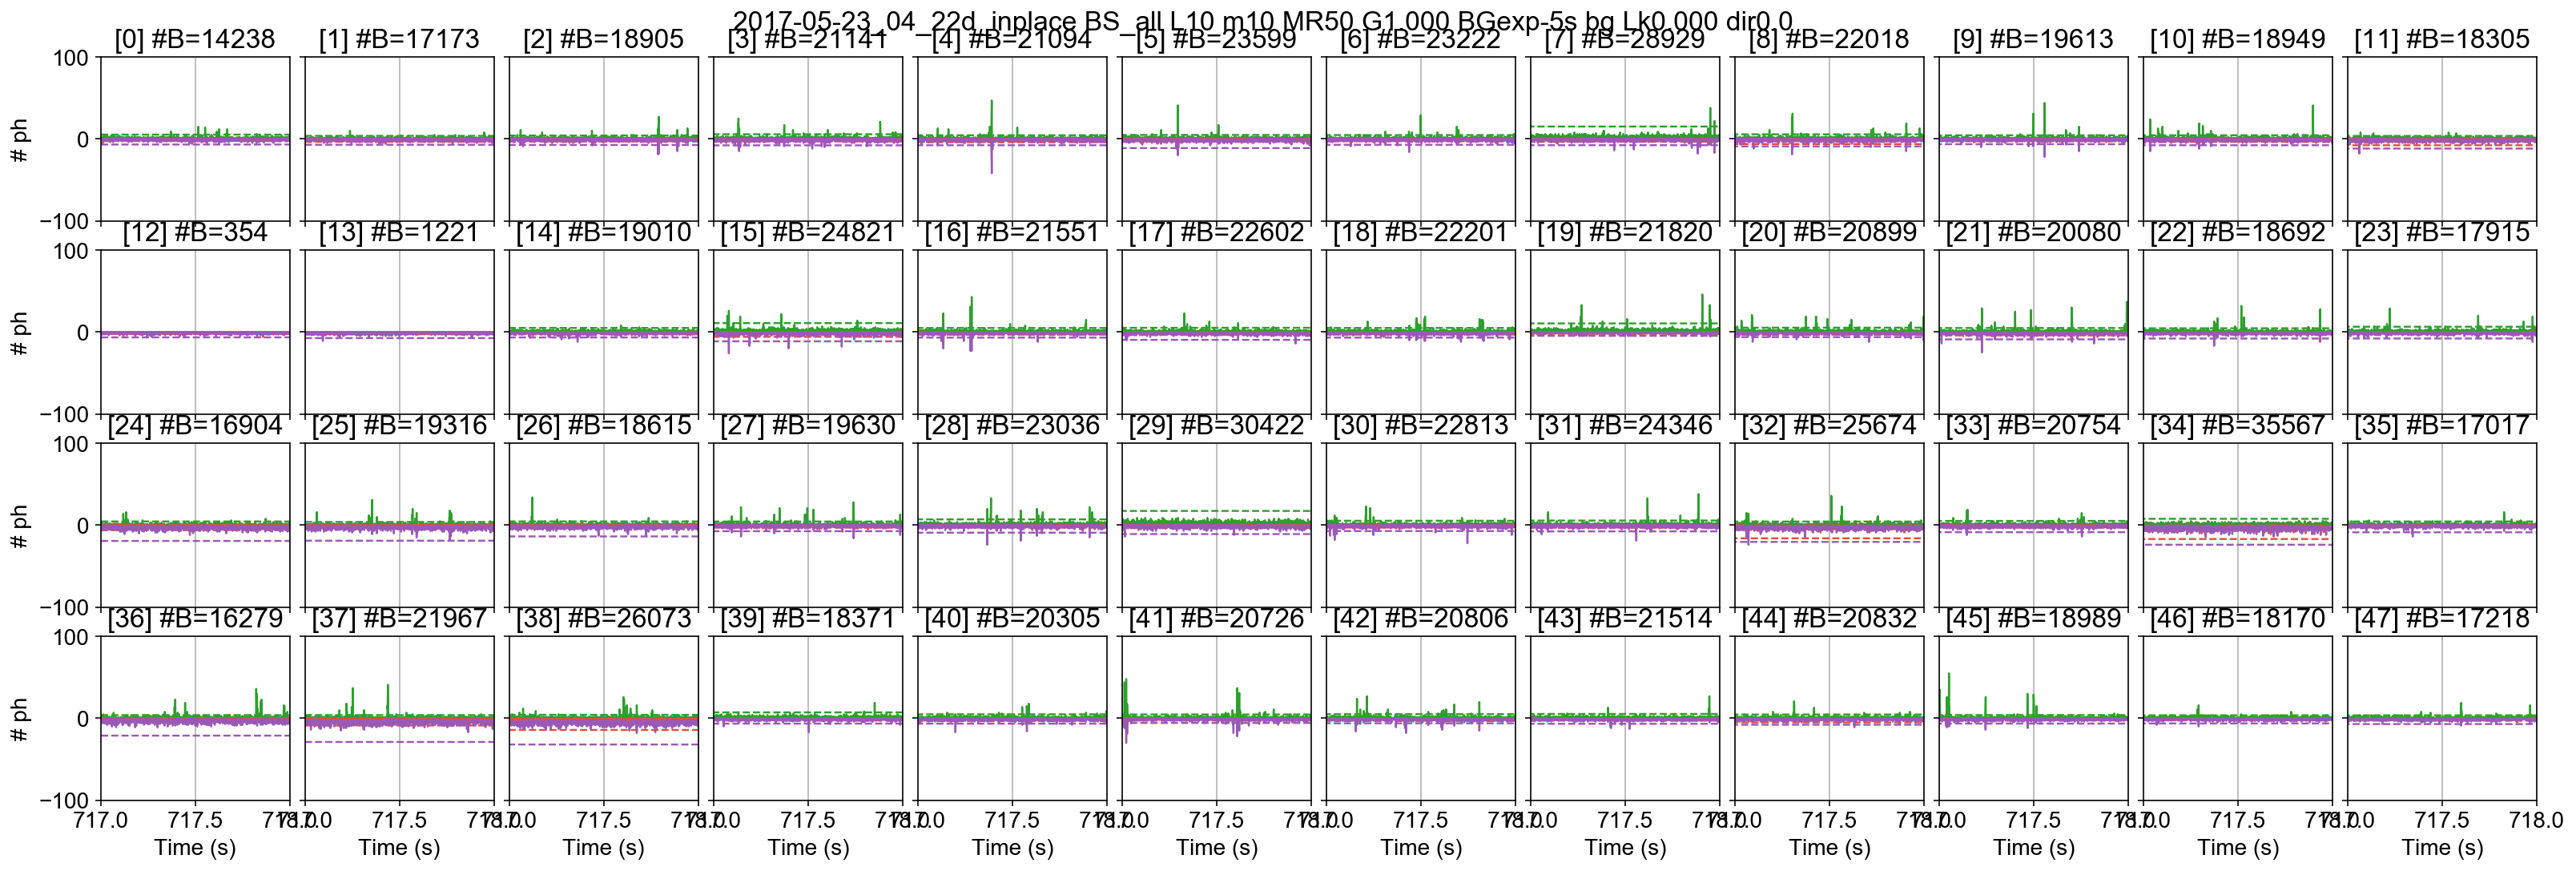

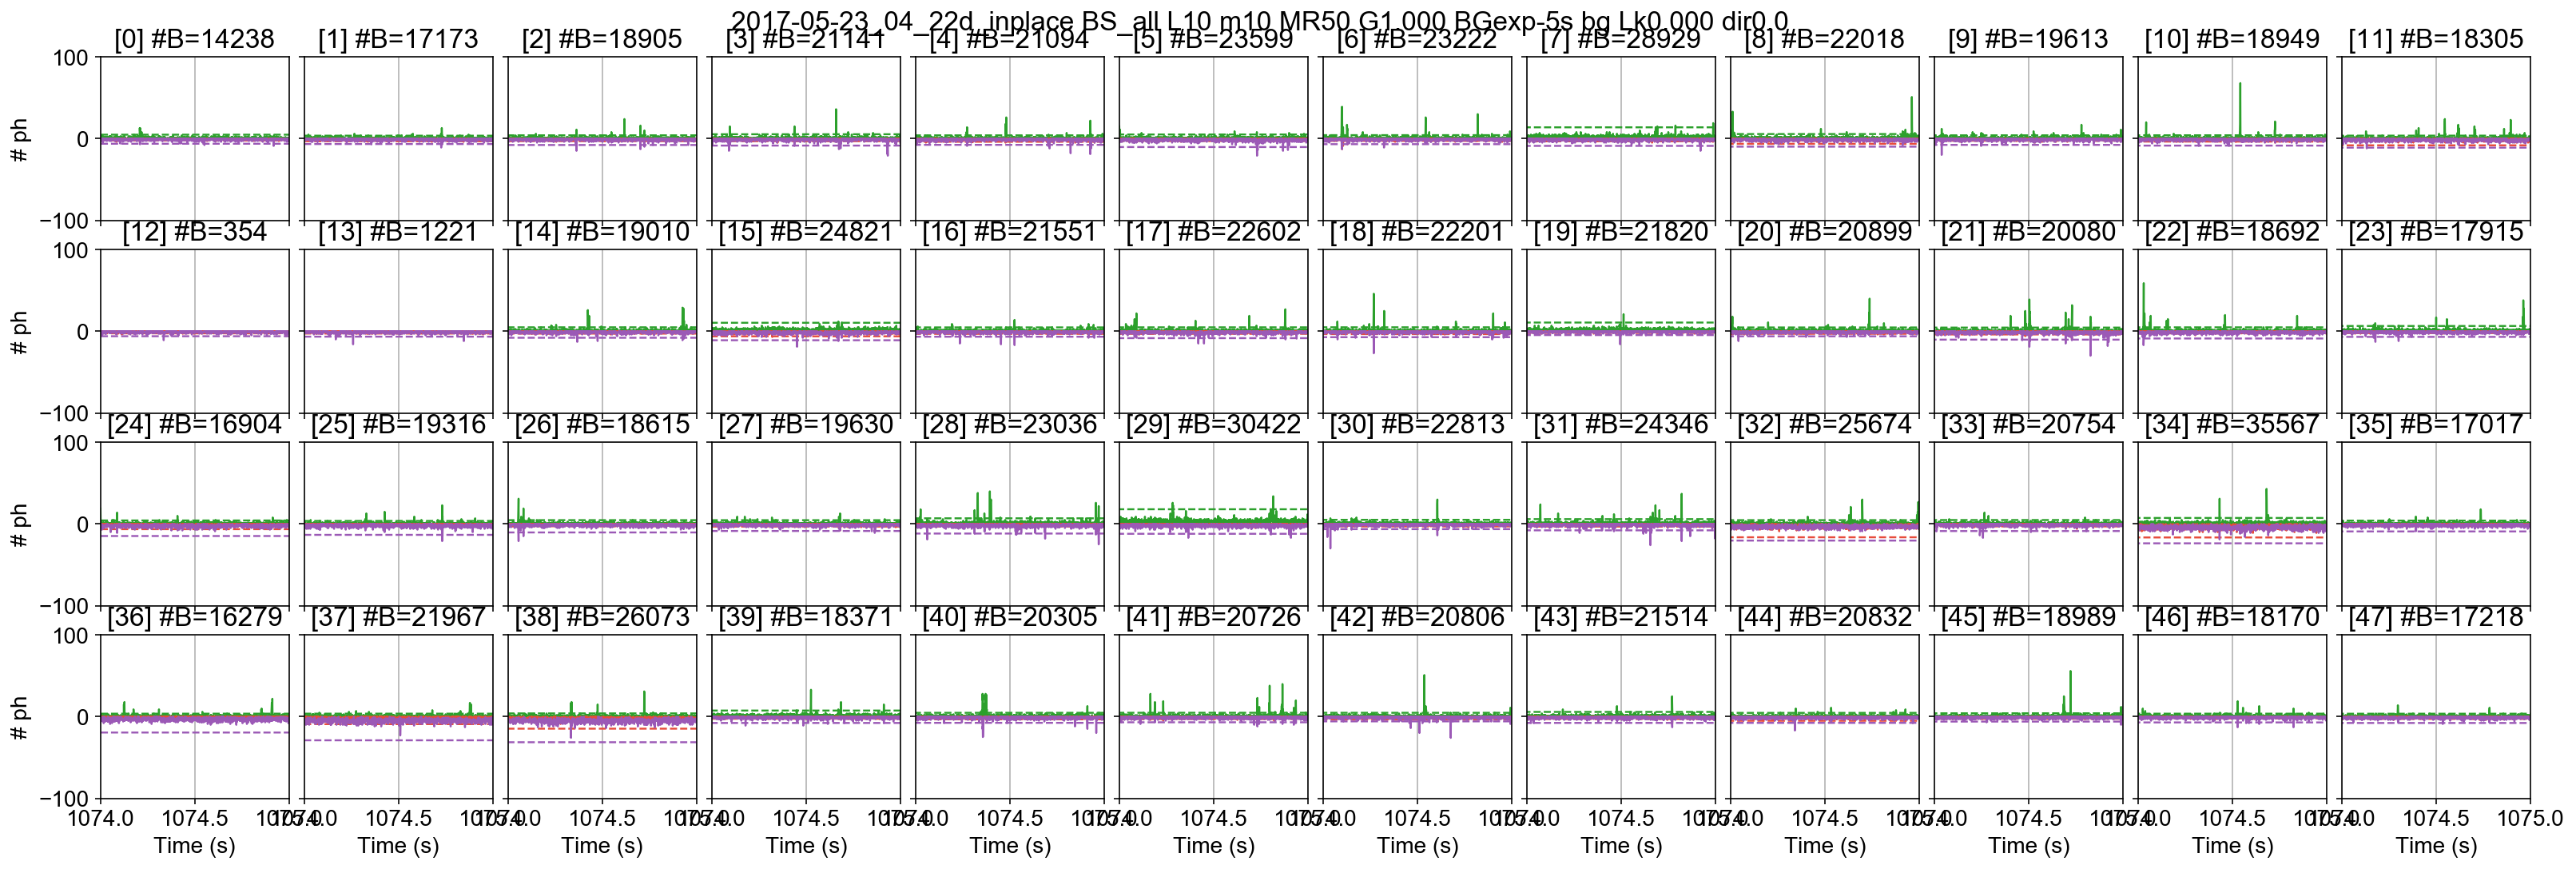

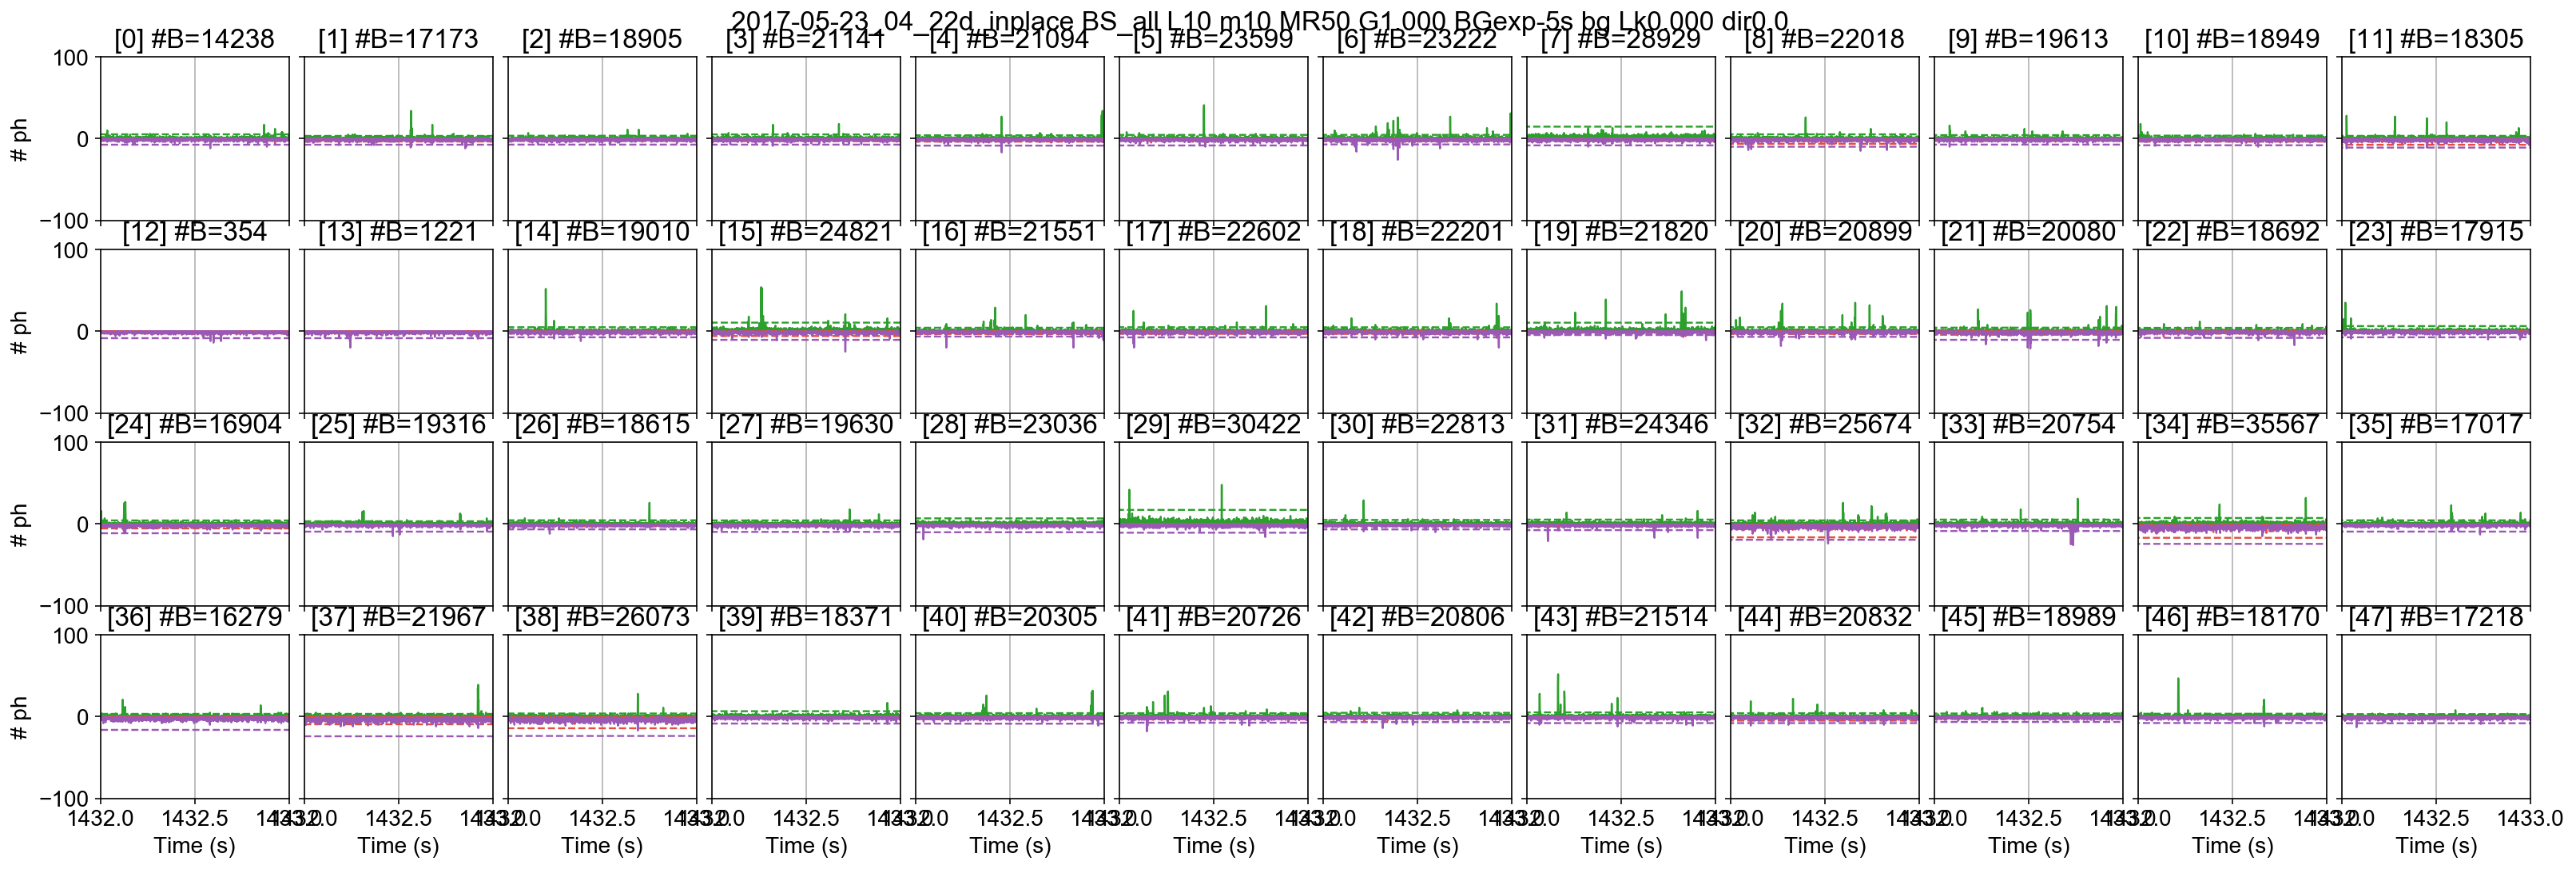

In [139]:
if plot_timetraces:
    num_time_points = 5

    # Timepoints equally distributed along the measurement
    time_points = np.round(np.linspace(d.time_min+1, d.time_max-2, num=num_time_points))

    for i in time_points:
        dplot(d, timetrace, tmin=i, tmax=i+1, figsize=(24, 8));
        plt.ylim(-100, 100)
        #savefig("%s_timetrace_t=%d-%d.png" % (mlabel, i, i+1))

## Background

In [ ]:
d.calc_bg_cache(bg.exp_fit, time_s=5, tail_min_us='auto', F_bg=1.7)

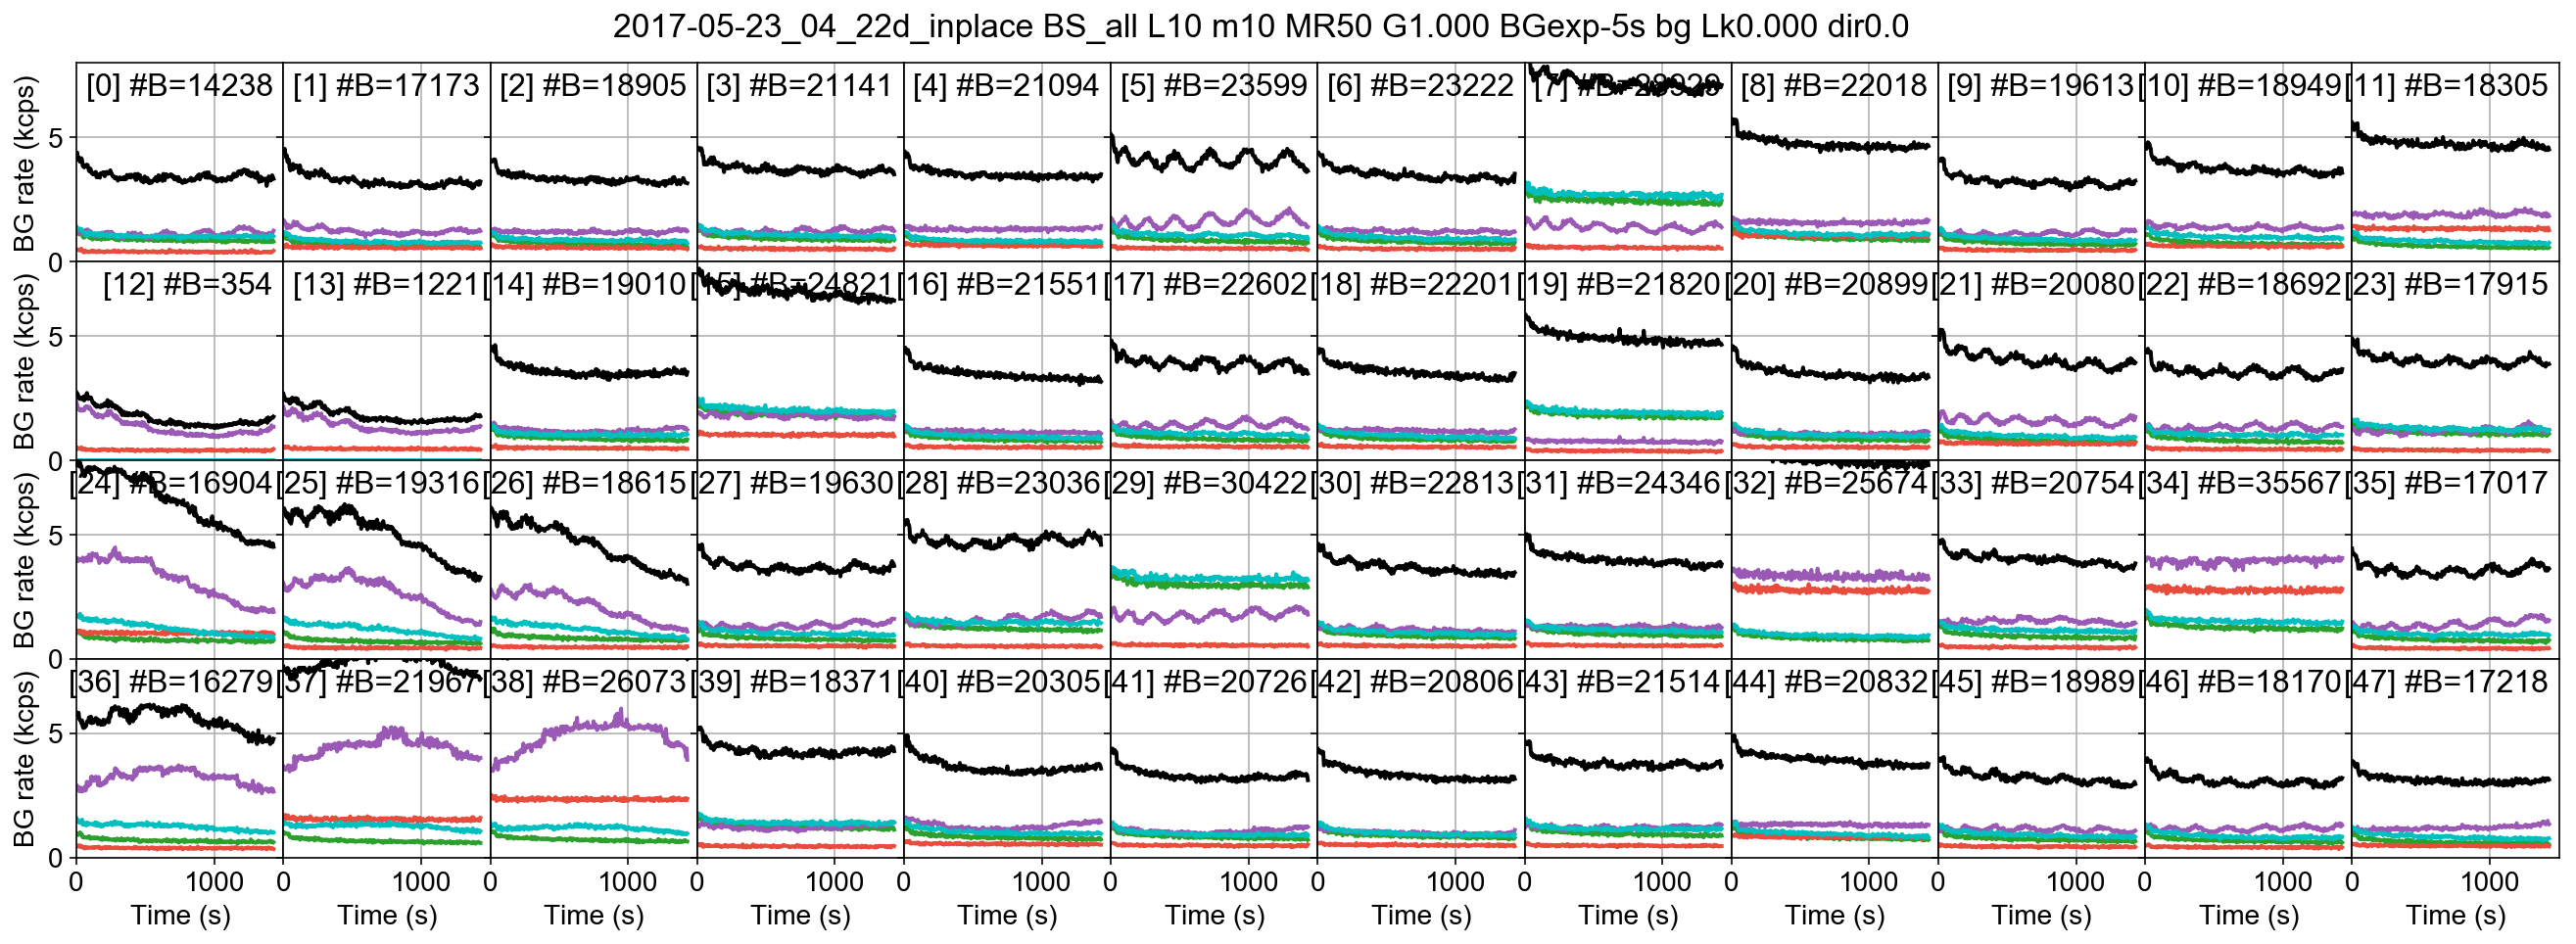

In [135]:
ax = dplot(d, timetrace_bg, show_da=True, hspace=0, wspace=0,
           plot_style=dict(marker=None), title='right top', 
           title_kws=dict(fontsize=16));
plt.xlim(0)
plt.ylim(0, 8);

In [136]:
bg_AexDem = d.bg_from(Ph_sel(Aex='Dem'))
bg_AexAem = d.bg_from(Ph_sel(Aex='Aem'))
bg_DexDem = d.bg_from(Ph_sel(Dex='Dem'))
bg_DexAem = d.bg_from(Ph_sel(Dex='Aem'))

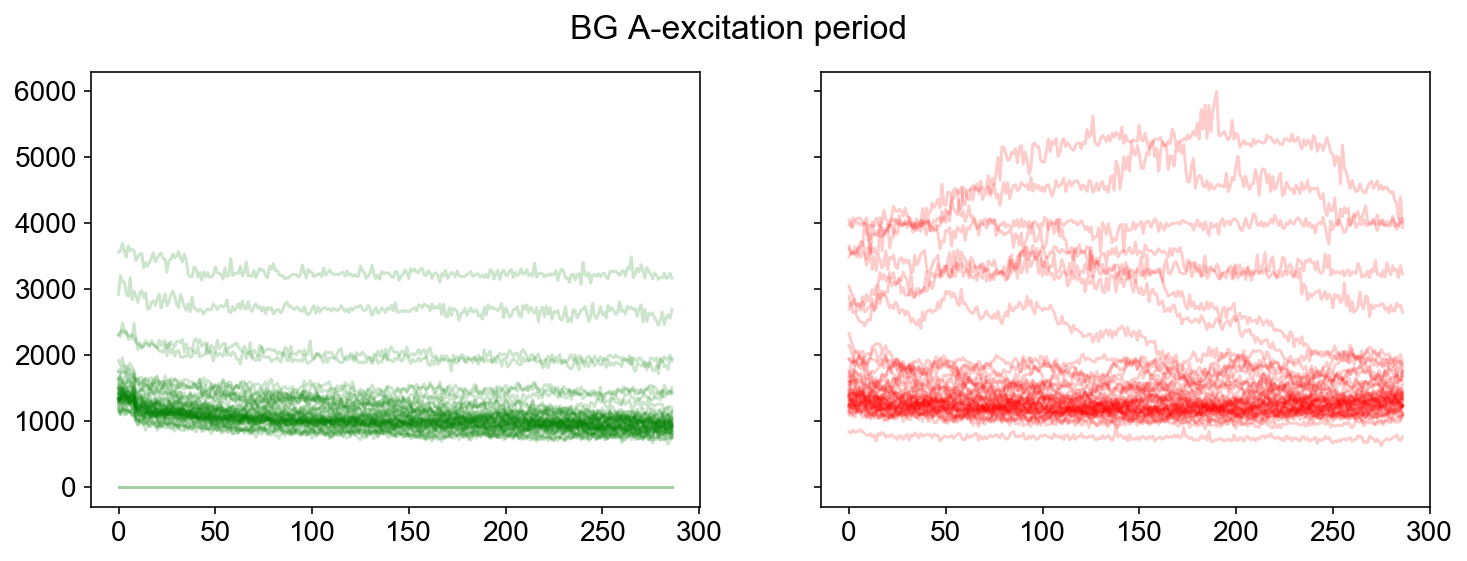

In [137]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
fig.suptitle("BG A-excitation period")
ax[0].plot(np.array(bg_AexDem).T, color='g', alpha=0.2);
ax[1].plot(np.array(bg_AexAem).T, color='r', alpha=0.2);

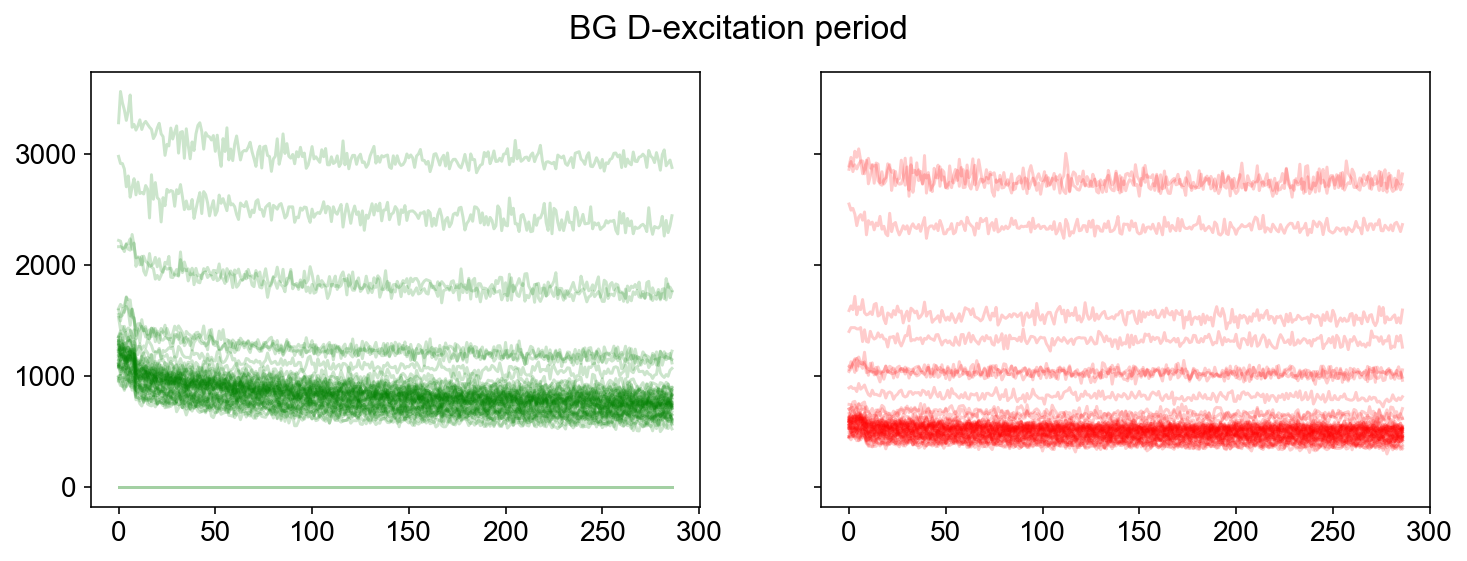

In [138]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
fig.suptitle("BG D-excitation period")
ax[0].plot(np.array(bg_DexDem).T, color='g', alpha=0.2);
ax[1].plot(np.array(bg_DexAem).T, color='r', alpha=0.2);

## Burst search

In [ ]:
d.burst_search(min_rate_cps=50e3, pax=True)

In [ ]:
kws = dict(skip_ch=(12, 13), hspace=0, wspace=0, top=0.96, 
           title_bg=False, title_nbursts=False, title='in')

In [ ]:
size_th = 15
size_sel_kws = dict(add_aex=True)
dplot(d, hist_size, vline=size_th, **size_sel_kws, **kws);
plt.xlim(-10, 250)
plt.legend();

In [ ]:
bs_mean = []
for i in range(48):
    sizes_ch = d.burst_sizes_pax_ich(i, **size_sel_kws) 
    tail = sizes_ch > size_th
    bs_mean.append(sizes_ch[tail].mean() - size_th)

In [ ]:
heatmap48(bs_mean, cmap='viridis', skip_ch=(12, 13),
          title="Mean Burst Sizes", vmin=10)
savefig('heatmap_burst_sizes')

In [ ]:
width_th = 0.4
dplot(d, hist_width, vline=width_th, **kws);
plt.xlim(-0.5, 4)

In [ ]:
bw_mean = []
for i in range(48):
    widths_ch = d.mburst[i].width * d.clk_p * 1e3
    tail = widths_ch > width_th
    bw_mean.append(widths_ch[tail].mean() - width_th)

In [ ]:
heatmap48(bw_mean, cmap='viridis', skip_ch=(12, 13),
          title="Mean Burst Width (ms)", vmin=0.1)
savefig('heatmap_burst_widths')

In [ ]:
# Use recompute=True if changing burst-search parameters
recompute = False
phrates = {}
streams = ('all', 'DexDem', 'AexDem', 'DexAem', 'AexAem', )
for stream in streams:
    print(' - Computing peak photon rates for %6s stream.' % str(Ph_sel.from_str(stream)))
    cal_phrate(d, stream=Ph_sel.from_str(stream), phrates=phrates, recompute=recompute)

In [ ]:
kws = dict(skip_ch=(12, 13), wspace=0, hspace=0, grid=True, vline=60,
           title='in', title_nbursts=False, title_bg=False)

In [ ]:
dplot(phrates['AexAemB'], hist_burst_phrate, plot_style=dict(color=bpl.purple), **kws);

Saved: figures/2017-05-23_04_22d_peak_phrate_all.png


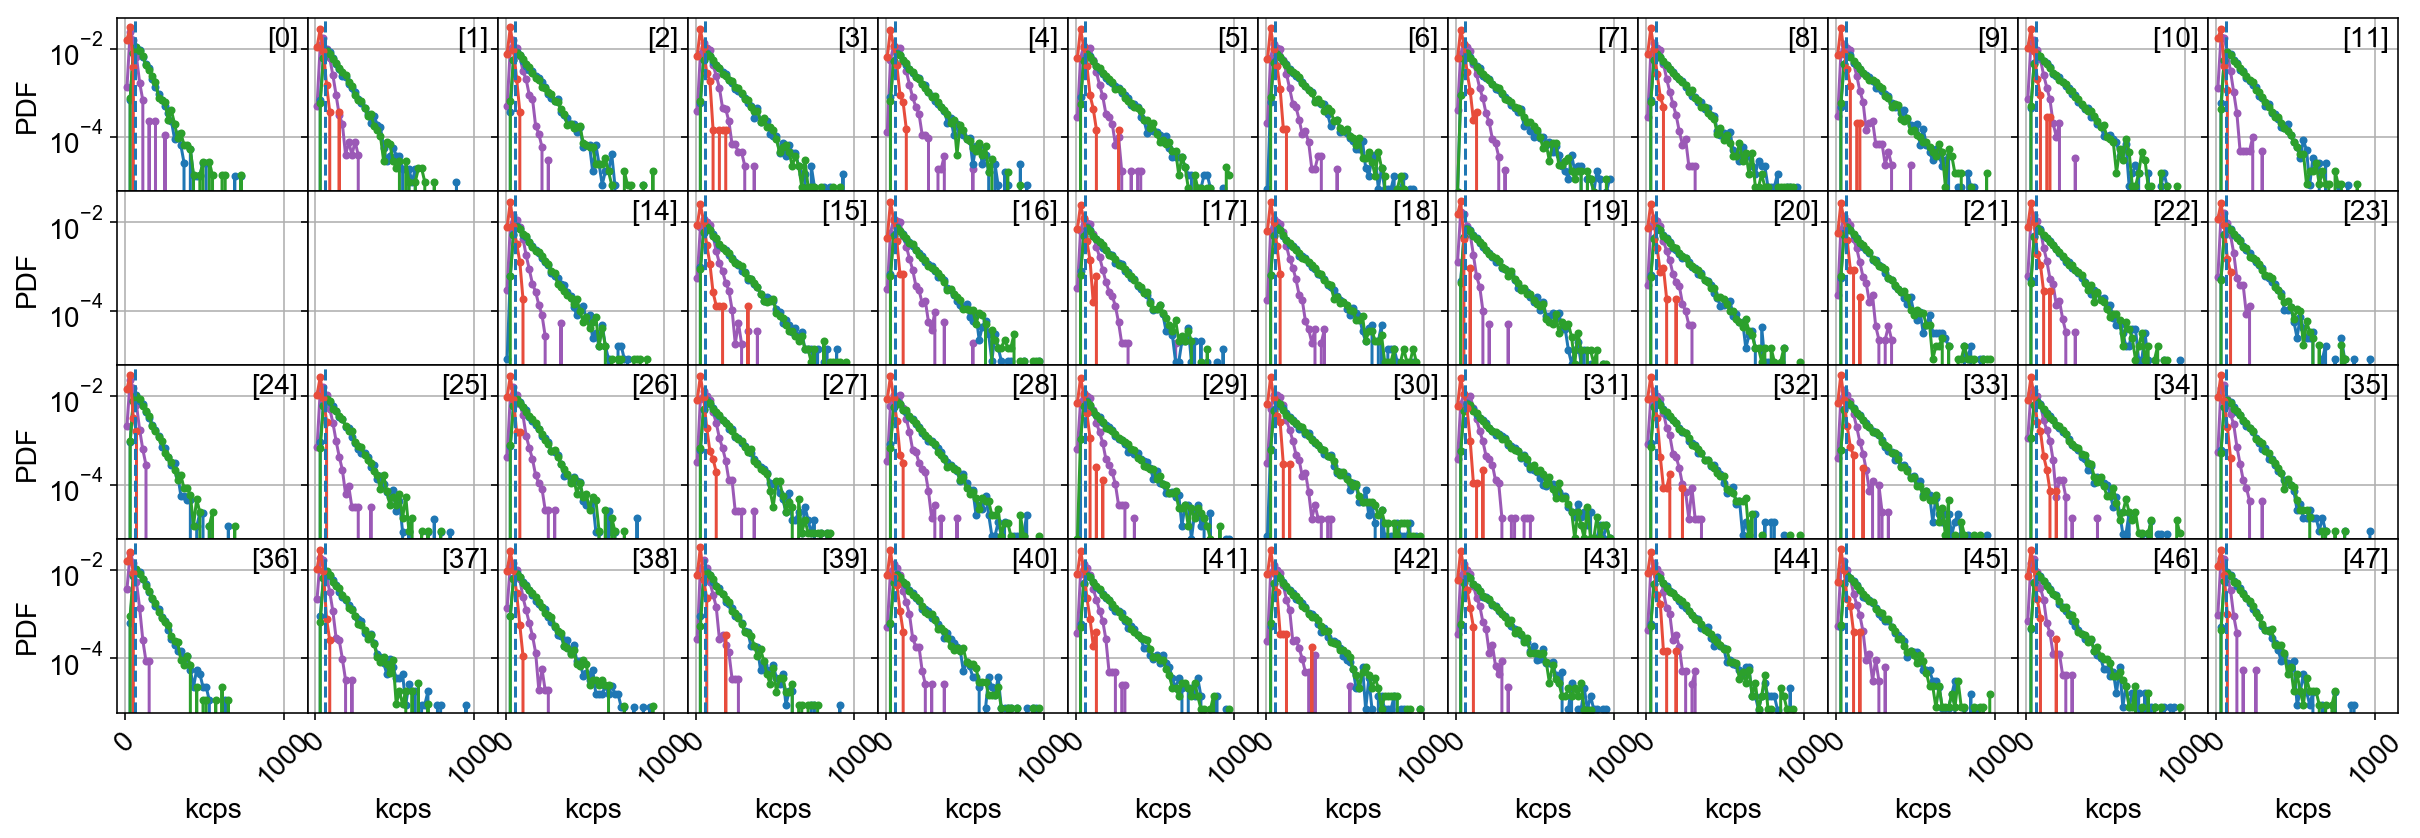

In [132]:
kws = dict(figsize=(18, 6), skip_ch=(12, 13), wspace=0, hspace=0, grid=True, 
           title=None, title_nbursts=False, title_bg=False, xrotation=45)

ax = dplot(phrates['AexAemB'], hist_burst_phrate, 
           plot_style=dict(color=bpl.purple, ms=3), **kws);
dplot(phrates['AexDemB'], hist_burst_phrate, 
      plot_style=dict(color='C0', ms=3), AX=ax, **kws);
dplot(phrates['DexDemB'], hist_burst_phrate, 
      plot_style=dict(color=bpl.green, ms=3), AX=ax, **kws);
kws.update(vline=60, title='in', title_nbursts=False, title_bg=False,)
dplot(phrates['DexAemB'], hist_burst_phrate, 
      plot_style=dict(color=bpl.red, ms=3), AX=ax, **kws);
plt.xlim(-50, 1150);
plt.setp(ax[:, 0], ylabel='PDF')
plt.setp(ax[-1], xlabel='kcps')
savefig('peak_phrate_all')

In [128]:
phr_th = 60e3
for stream in streams:
    phrates[stream]['mean'] = 0
    phr = phrates[stream+'B']
    for ich in range(48):
        valid = ~pd.isnull(phr[ich])
        phr_valid = phr[ich][valid]
        m = phr_valid[phr_valid >= phr_th].mean() - phr_th
        phrates[stream].loc[ich, 'mean'] = np.round(m*1e-3, 1)

In [129]:
streams

('all', 'DexDem', 'AexDem', 'DexAem', 'AexAem')

Saved: figures/2017-05-23_04_22d_peak_phrate_heatmap_all.png
Saved: figures/2017-05-23_04_22d_peak_phrate_heatmap_DexDem.png
Saved: figures/2017-05-23_04_22d_peak_phrate_heatmap_AexDem.png
Saved: figures/2017-05-23_04_22d_peak_phrate_heatmap_DexAem.png
Saved: figures/2017-05-23_04_22d_peak_phrate_heatmap_AexAem.png


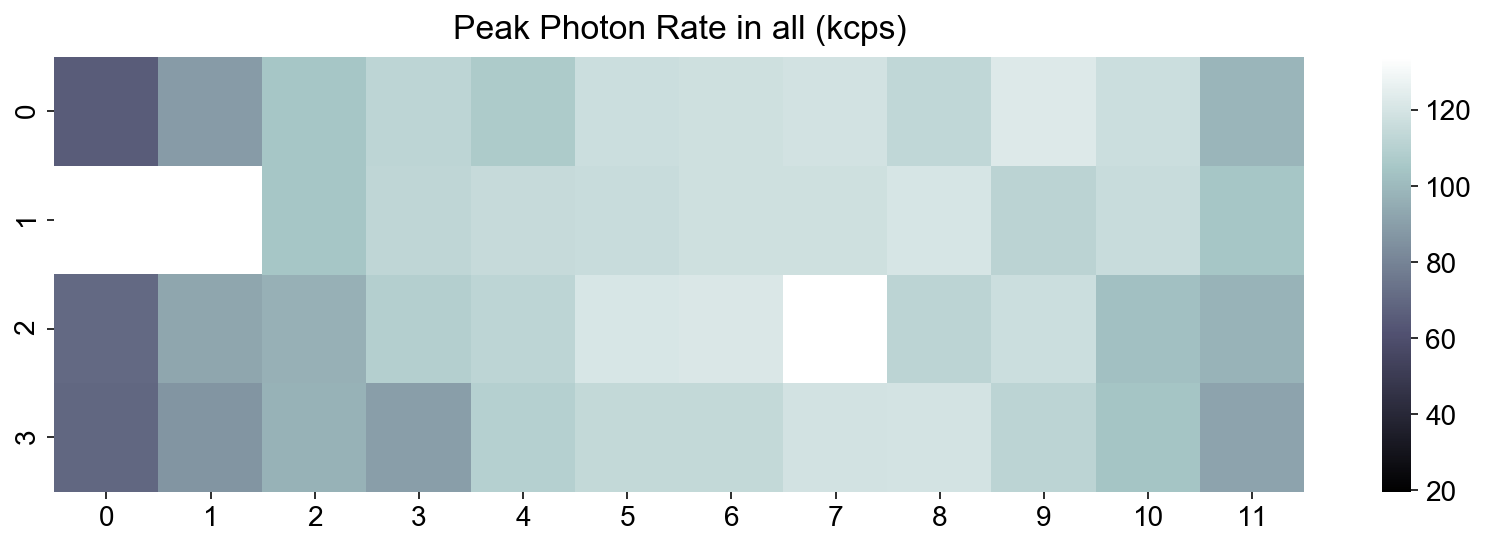

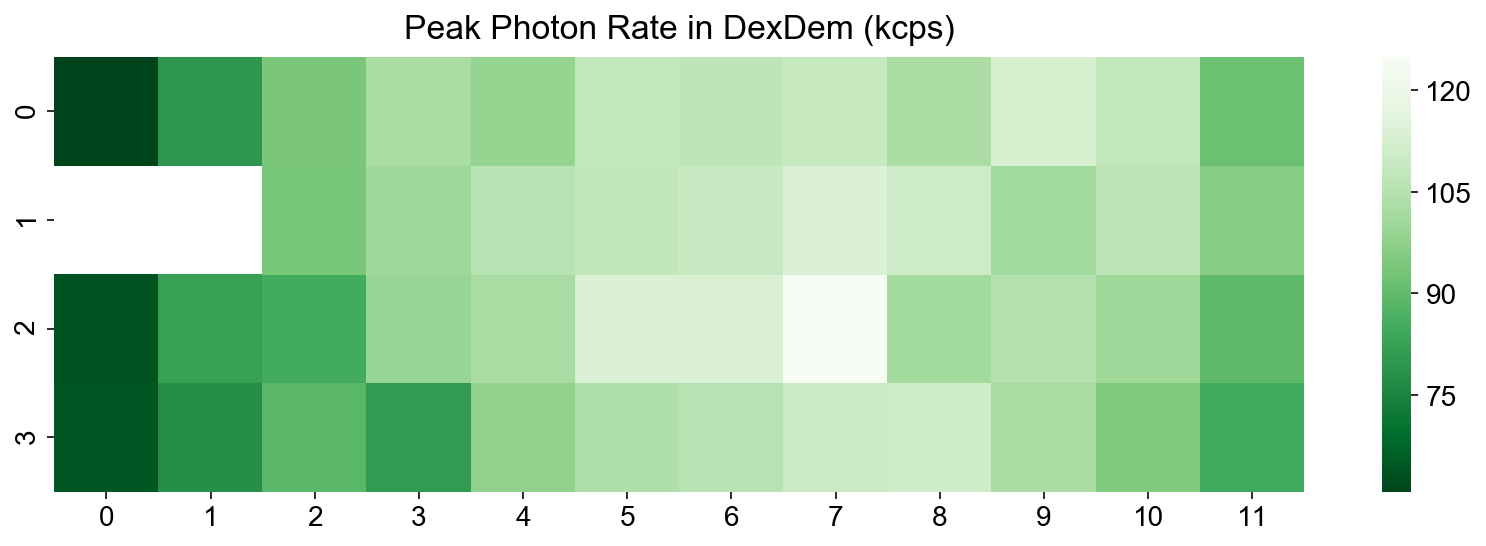

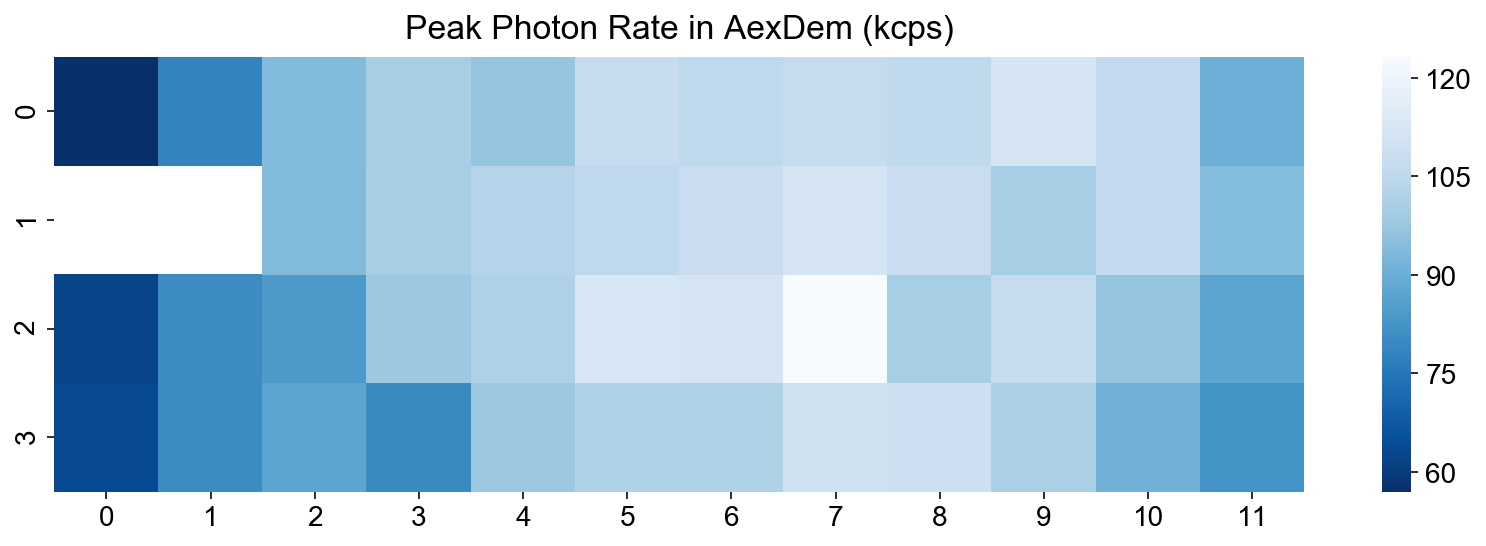

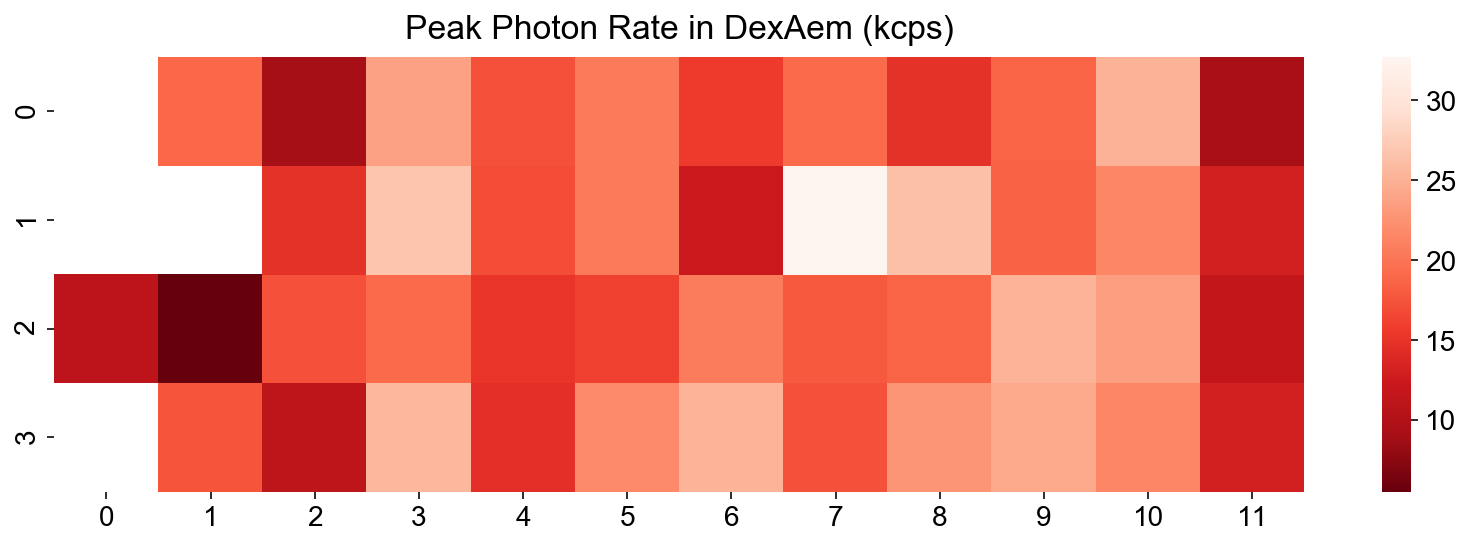

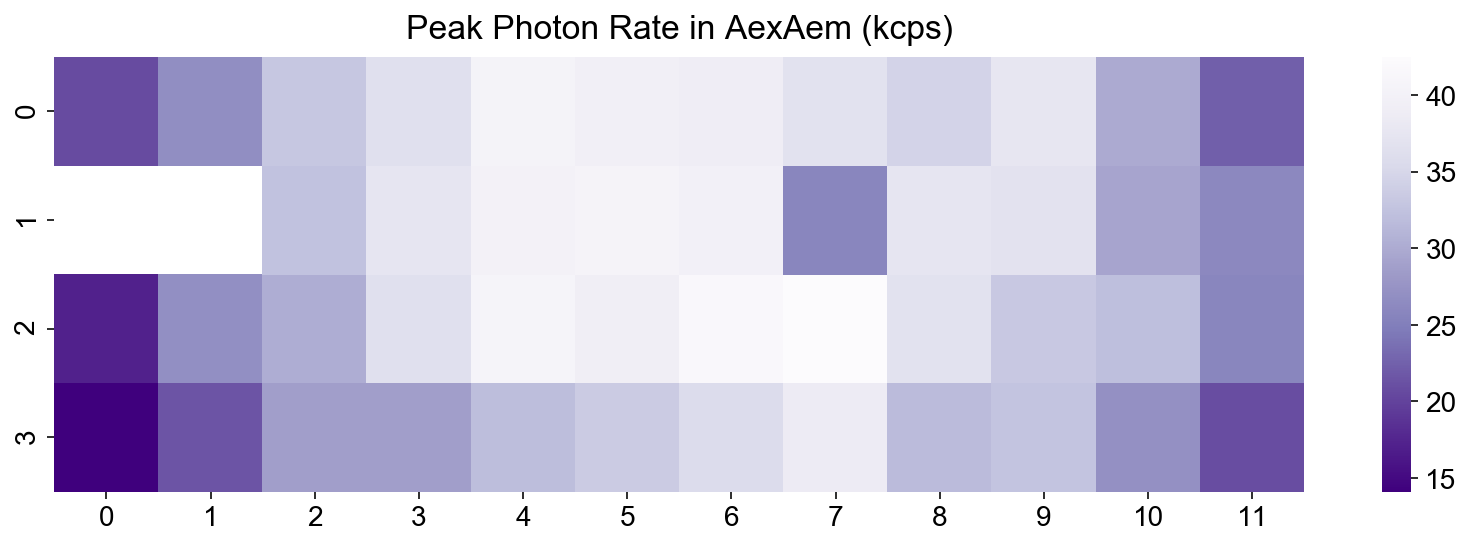

In [130]:
cmaps = ('bone', 'Greens_r', 'Blues_r', 'Reds_r', 'Purples_r')
for stream, cmap in zip(streams, cmaps):
    heatmap48(phrates[stream]['mean'], cmap=cmap, skip_ch=(12, 13),
              title="Peak Photon Rate in %s (kcps)" % stream)
    savefig('peak_phrate_heatmap_%s' % stream)

## Burst selection

In [142]:
th1 = 40
ds = d.select_bursts(select_bursts.size, th1=th1, gamma=0.5, add_aex=True)

Su = [(nd + na)/(nd + na + naa) for nd, na, naa in zip(ds.nd, ds.na, ds.naa)]
ds.add(Su=Su)

In [ ]:
ax = dplot(ds, hist_fret, pdf=False, skip_ch=(12, 13));
plt.setp(ax[:, 0], ylabel='# Bursts');
# plt.ylim(0, 600);
savefig('48spot hist E all-bursts')

In [ ]:
ax = dplot(ds, hist_S, pdf=False, skip_ch=(12, 13));
plt.setp(ax[:, 0], ylabel='# Bursts');
savefig('48spot hist S all-bursts')

In [ ]:
dplot(ds, hist_burst_data, data_name='Su', pdf=False, skip_ch=(12, 13));
plt.setp(ax[:, 0], ylabel='# Bursts');
savefig('48spot hist Su')

In [ ]:
ax = dplot(ds, hexbin_alex, vmax=10, skip_ch=(12, 13), wspace=0, hspace=0, gridsize=60,
           title='bottom left', title_bg=False);
ax0 = ax[0,0]
fig = ax0.figure
cax = fig.add_axes([0.97, 0.25, 0.01, 0.5])
plt.colorbar(cax=cax)
plt.setp(ax[:, 0], ylabel='S');
ax0.set_xticks([0, 0.5, 1])
ax0.set_yticks([0, 0.5, 1]);
ax0.set_xlim(-0.2, 1)
ax0.set_ylim(0, 1.2);
savefig('48spot alex hist S all-bursts')

Saved: figures/2017-05-23_04_22d_48spot_alex_hist_Su_all-bursts.png


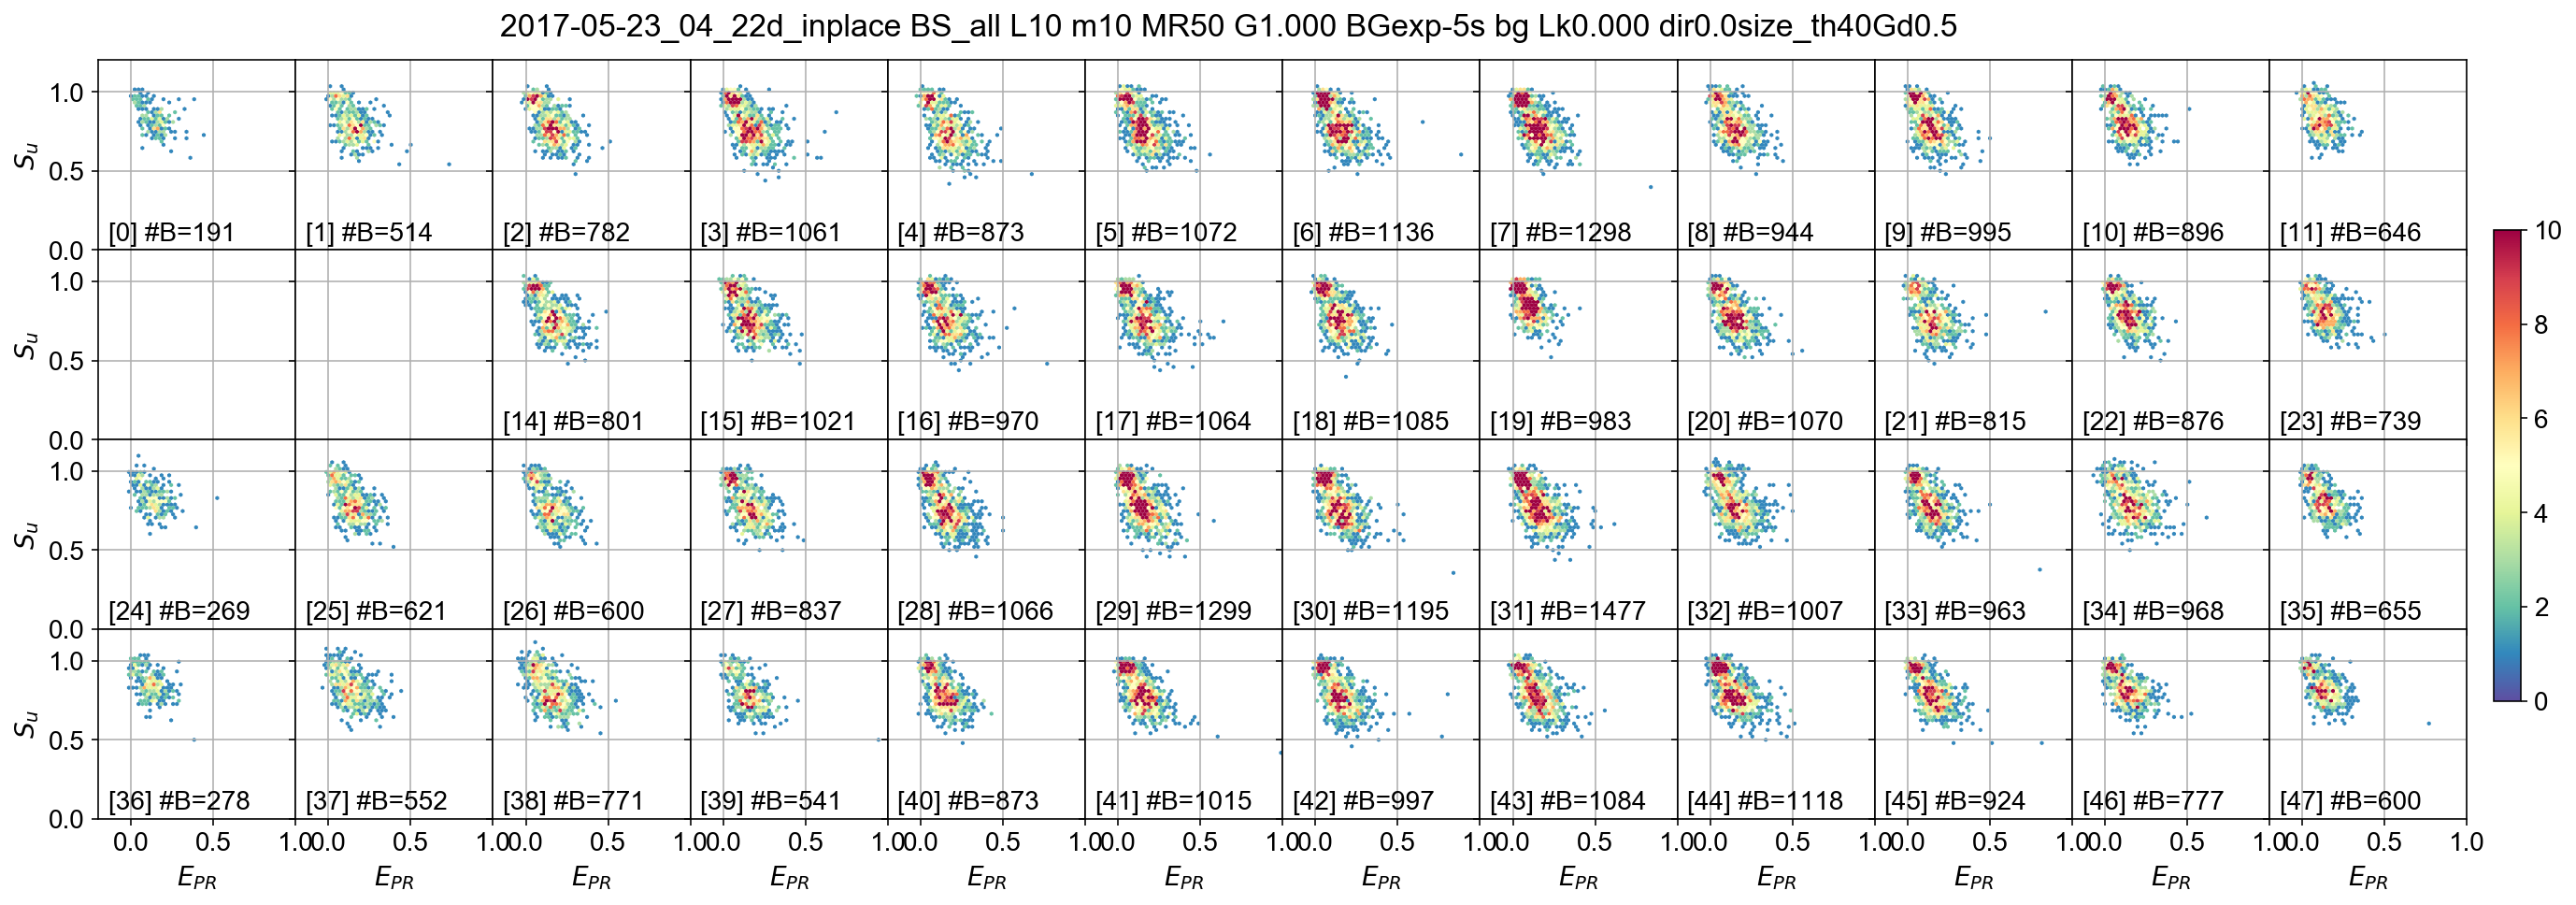

In [143]:
ax = dplot(ds, hexbin_alex, vmax=10, S_name='Su', skip_ch=(12, 13), 
           wspace=0, hspace=0, gridsize=60, title='bottom left', title_bg=False);
ax0 = ax[0, 0]
fig = ax0.figure
cax = fig.add_axes([0.97, 0.25, 0.01, 0.5])
plt.setp(ax[:, 0], ylabel='$S_u$');
plt.setp(ax[-1], xlabel='$E_{PR}$');
plt.colorbar(cax=cax)
ax0.set_xticks([0, 0.5, 1])
ax0.set_yticks([0, 0.5, 1]);
ax0.set_xlim(-0.2, 1)
ax0.set_ylim(0, 1.2);
savefig('48spot alex hist Su all-bursts')

In [144]:
th1 = 20
dss1 = d.select_bursts(select_bursts.naa, th1=th1)
dss = dss1.select_bursts(select_bursts.size, th1=th1, gamma=0.5)

Su = [(nd + na)/(nd + na + naa) for nd, na, naa in zip(dss.nd, dss.na, dss.naa)]
dss.add(Su=Su)

Saved: figures/2017-05-23_04_22d_48spot_alex_hist_Su_naa_AND_size_selection.png


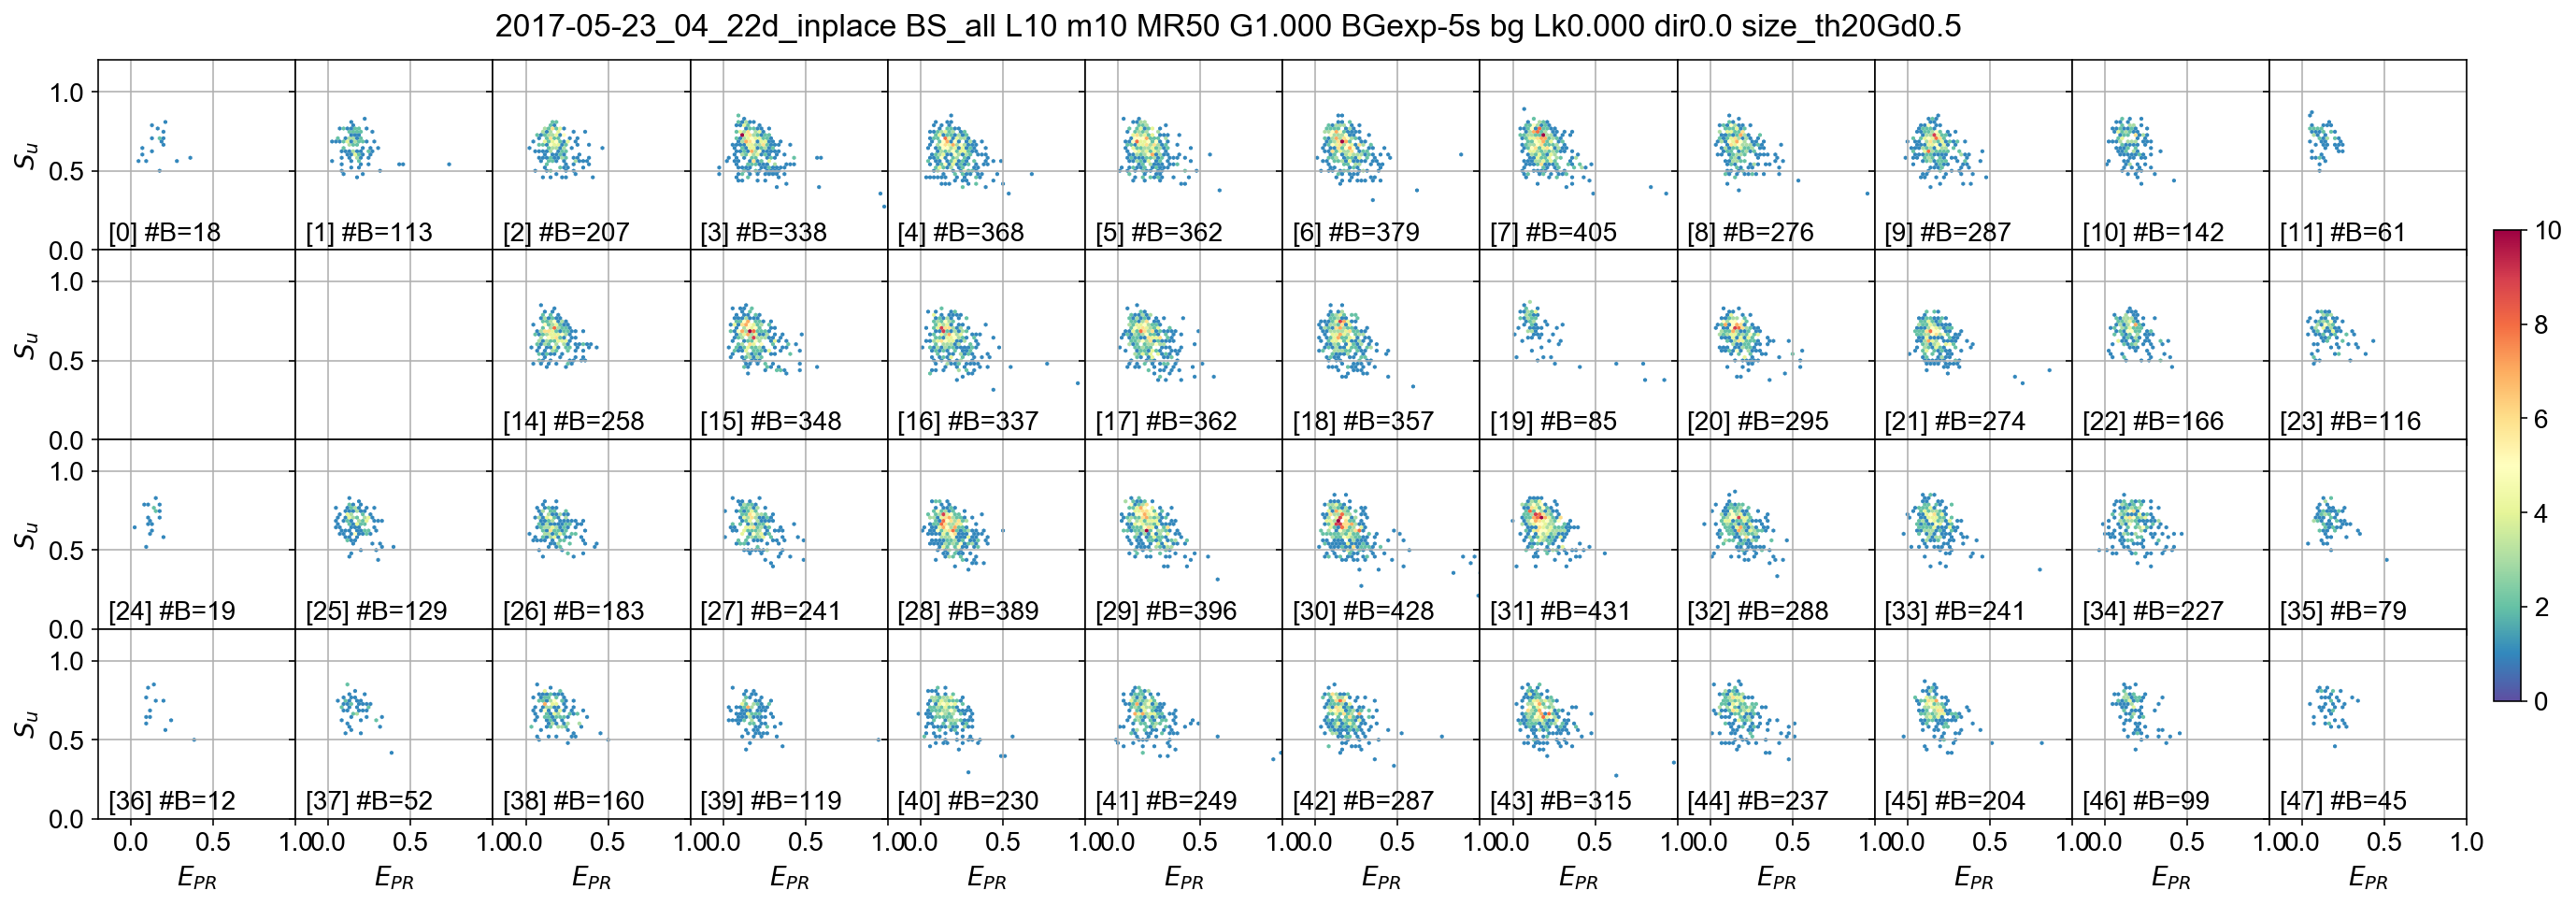

In [145]:
ax = dplot(dss, hexbin_alex, vmax=10, S_name='Su', skip_ch=(12, 13), 
           wspace=0, hspace=0, gridsize=60, title='bottom left', title_bg=False);
ax0 = ax[0,0]
fig = ax0.figure
cax = fig.add_axes([0.97, 0.25, 0.01, 0.5])
plt.colorbar(cax=cax)
plt.setp(ax[:, 0], ylabel='$S_u$');
plt.setp(ax[-1], xlabel='$E_{PR}$');
ax0.set_xticks([0, 0.5, 1])
ax0.set_yticks([0, 0.5, 1]);
ax0.set_xlim(-0.2, 1)
ax0.set_ylim(0, 1.2);
savefig('48spot alex hist Su naa AND size selection')

## DCBS

In [ ]:
and_gate_min_rate_cps

In [ ]:
and_gate_size_sel_kws

In [ ]:
d2 = bext.burst_search_and_gate(d, min_rate_cps=and_gate_min_rate_cps)

In [ ]:
and_gate_size_sel_kws

In [ ]:
ds2 = d2.select_bursts(select_bursts.size, **and_gate_size_sel_kws)

Su = [(nd + na)/(nd + na + naa) for nd, na, naa in zip(ds2.nd, ds2.na, ds2.naa)]
ds2.add(Su=Su)

Saved: figures/2017-05-23_04_22d_48spot_alex_hist_Su_DCBS.png


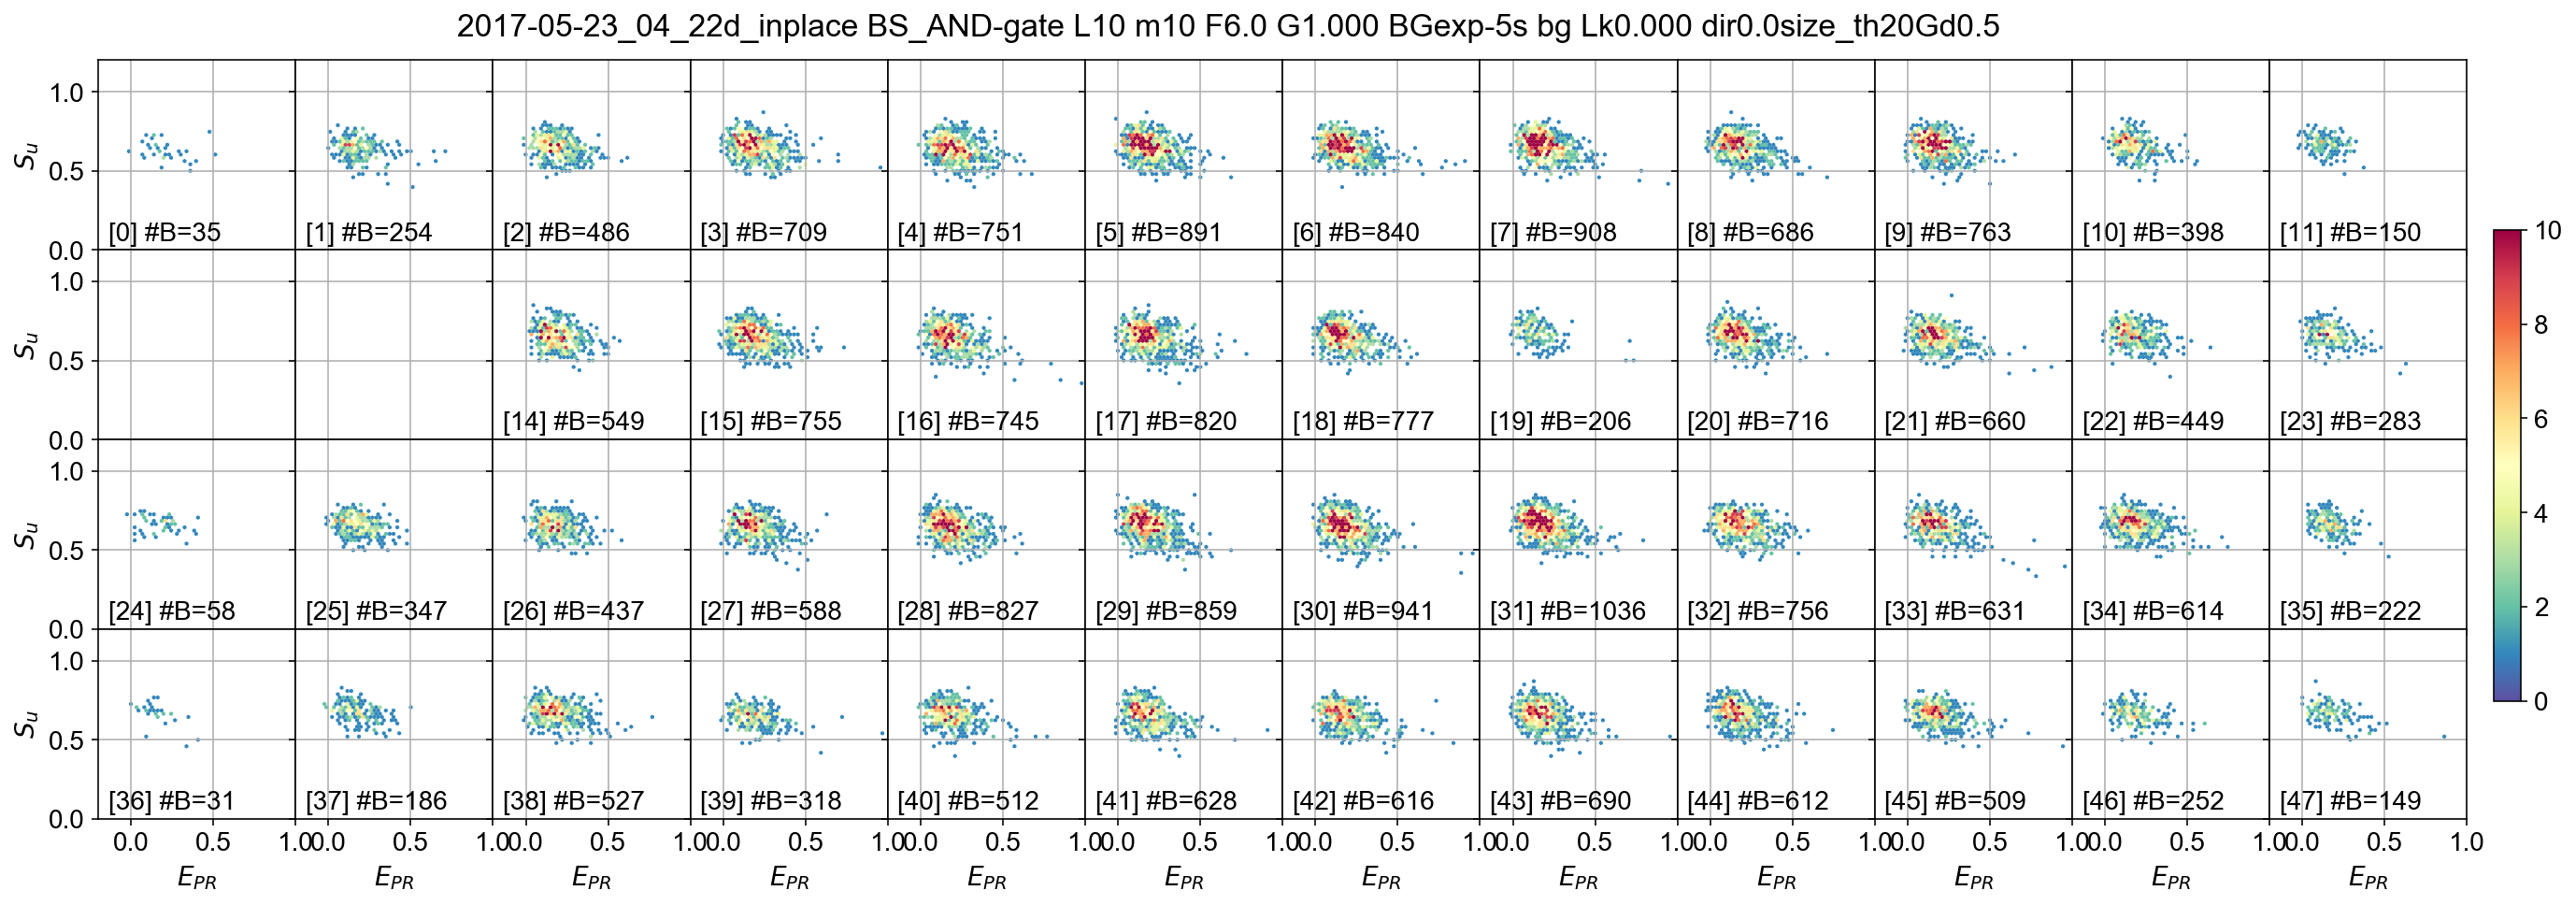

In [134]:
ax = dplot(ds2, hexbin_alex, vmax=10, S_name='Su', skip_ch=(12, 13), 
           wspace=0, hspace=0, gridsize=60, title='bottom left', title_bg=False);
ax0 = ax[0,0]
fig = ax0.figure
cax = fig.add_axes([0.97, 0.25, 0.01, 0.5])
plt.colorbar(cax=cax)
plt.setp(ax[:, 0], ylabel='$S_u$');
plt.setp(ax[-1], xlabel='$E_{PR}$');
ax0.set_xticks([0, 0.5, 1])
ax0.set_yticks([0, 0.5, 1]);
ax0.set_xlim(-0.2, 1)
ax0.set_ylim(0, 1.2);
savefig('48spot alex hist Su DCBS')

In [ ]:
dsaa = d.select_bursts(select_bursts.naa, th1=15)
Su = [(nd + na)/(nd + na + naa) for nd, na, naa in zip(dsaa.nd, dsaa.na, dsaa.naa)]
dsaa.add(Su=Su)

In [ ]:
ax = dplot(dsaa, hexbin_alex, vmax=20, S_name='Su', skip_ch=(12, 13), 
           wspace=0, hspace=0, gridsize=60, title='bottom left', title_bg=False);
ax0 = ax[0,0]
fig = ax0.figure
cax = fig.add_axes([0.97, 0.25, 0.01, 0.5])
plt.colorbar(cax=cax)
plt.setp(ax[:, 0], ylabel='$S_u$');
ax0.set_xticks([0, 0.5, 1])
ax0.set_yticks([0, 0.5, 1]);
savefig('48spot alex hist Su DCBS selection with A-only')

## Fitting

### FRET population fit

In [ ]:
ds_fret = dss

In [ ]:
E_fitter = bext.bursts_fitter(ds_fret, 'E', skip_ch=(12, 13))
model = mfit.factory_gaussian()
model.set_param_hint('center', value=0.5, min=0, max=1)
model.set_param_hint('sigma', value=0.1, min=0.03, max=0.2)
model.print_param_hints()

In [ ]:
E_fitter.fit_histogram(model, pdf=False, method='mealder')

In [ ]:
ax = dplot(ds_fret, hist_fret, pdf=False, show_model=True, skip_ch=(12, 13));
plt.setp(ax[:, 0], ylabel='# Bursts')
savefig('FRET pop - E hist fit')

In [ ]:
S_fitter = bext.bursts_fitter(ds_fret, 'S', skip_ch=(12, 13))
model = mfit.factory_gaussian()
model.set_param_hint('center', value=0.5, min=0, max=1)
model.set_param_hint('sigma', value=0.1, min=0.03, max=0.2)
model.print_param_hints()

In [ ]:
S_fitter.fit_histogram(model, pdf=False, method='mealder')

In [ ]:
ax = dplot(ds_fret, hist_S, pdf=False, show_model=True, skip_ch=(12, 13));
plt.setp(ax[:, 0], ylabel='# Bursts')
savefig('FRET pop - E hist fit');

In [ ]:
Su_fitter = bext.bursts_fitter(ds_fret, 'Su', skip_ch=(12, 13))
model = mfit.factory_gaussian()
model.set_param_hint('center', value=0.5, min=0, max=1)
model.set_param_hint('sigma', value=0.1, min=0.03, max=0.2)
model.print_param_hints()

In [ ]:
Su_fitter.fit_histogram(model, pdf=False, method='mealder')

In [ ]:
ax = dplot(ds_fret, hist_burst_data, data_name='Su', pdf=False, show_model=True, skip_ch=(12, 13));
plt.setp(ax[:, 0], ylabel='# Bursts')
savefig('FRET pop - Su hist fit');

### FRET population tidy

In [ ]:
def make_ES_fit_dataframe(E_df_fitt, S_df_fitt, Su_df_fitt, dx, skip_ch=(12, 13)):
    pop_peak = E_df_fitt.query('name == "center"').loc[:,('value', 'spot')].set_index('spot')
    pop_peak.columns = ['E']
    pop_peak['S'] = S_df_fitt.query('name == "center"').loc[:,('value', 'spot')].set_index('spot')
    pop_peak['Su'] = Su_df_fitt.query('name == "center"').loc[:,('value', 'spot')].set_index('spot')
    pop_peak['num_bursts'] = dx.num_bursts

    pop_peak['E_sigma'] = E_df_fitt.query('name == "sigma"').loc[:,('value', 'spot')].set_index('spot')
    pop_peak['S_sigma'] = S_df_fitt.query('name == "sigma"').loc[:,('value', 'spot')].set_index('spot')
    pop_peak['Su_sigma'] = Su_df_fitt.query('name == "sigma"').loc[:,('value', 'spot')].set_index('spot')

    pop_peak['E_err'] = pop_peak['E_sigma'] / np.sqrt(pop_peak['num_bursts'])
    pop_peak['S_err'] = pop_peak['S_sigma'] / np.sqrt(pop_peak['num_bursts'])
    pop_peak['Su_err'] = pop_peak['Su_sigma'] / np.sqrt(pop_peak['num_bursts'])

    pop_peak.loc[skip_ch, (c for c in pop_peak.columns if c != 'num_bursts')] = np.nan

    # Add categorical column for pixel grouping
    # spotv is a global var from heatmatp.py
    pixel_groups = {
        'center': spotsv[4:8],
        'top':    spotsv[:4],
        'bottom': spotsv[-4:]}
    cat = {}
    for i, row in pop_peak.iterrows():
        for group, group_vals in pixel_groups.items(): 
            if i in group_vals:
                cat[i] = group
    pop_peak['Pixel'] = pd.Series(cat, dtype="category")
    return pop_peak

In [ ]:
Efret_fitg = br.glance(E_fitter.fit_res, var_names='spot')
Sfret_fitg = br.glance(S_fitter.fit_res, var_names='spot')
Sufret_fitg = br.glance(Su_fitter.fit_res, var_names='spot')

In [ ]:
Efret_fitg.head(3)

In [ ]:
Sfret_fitg.head(3)

In [ ]:
Sufret_fitg.head(3)

In [ ]:
Efret_fitt = br.tidy(E_fitter.fit_res, var_names='spot')
Sfret_fitt = br.tidy(S_fitter.fit_res, var_names='spot')
Sufret_fitt = br.tidy(Su_fitter.fit_res, var_names='spot')
Efret_fitt.head()

In [ ]:
FRET_peak = make_ES_fit_dataframe(Efret_fitt, Sfret_fitt, Sufret_fitt, ds_fret)

In [ ]:
FRET_peak.head()

### FRET population plots

In [ ]:
binwidth = 0.02
bins= np.arange(-0.1, 1.1, binwidth) + 0.5*binwidth
labels = sorted(set(FRET_peak.Pixel))
Efret_groups = [np.array(FRET_peak.E[FRET_peak.Pixel == grp]) for grp in labels]

plt.hist(Efret_groups, bins=bins, range=(bins.min(), bins.max()), histtype='bar', stacked=True);
plt.xlabel('E')
plt.ylabel('# Spots')
plt.xlim(-0.1, 1.1)
plt.title('Distributions of FRET peak positions')
plt.legend(labels, title='Pixel group')
print('FRET pop: E mean [min, max] = %5.3f [%5.3f, %5.3f], σ = %5.3f' % 
      (FRET_peak.E.mean(), FRET_peak.E.min(), FRET_peak.E.max(), FRET_peak.E.std()))
savefig('FRET_peaks_distributions_grouped.png')

In [ ]:
binwidth = 0.02
bins= np.arange(-0.1, 1.1, binwidth) + 0.5*binwidth
labels = sorted(set(FRET_peak.Pixel))
Sfret_groups = [np.array(FRET_peak.S[FRET_peak.Pixel == grp]) for grp in labels]

plt.hist(Sfret_groups, bins=bins, range=(bins.min(), bins.max()), histtype='bar', stacked=True);
plt.xlabel('S')
plt.ylabel('# Spots')
plt.xlim(-0.1, 1.1)
plt.title('Distributions of S peak positions')
plt.legend(labels, title='Pixel group')
print('FRET pop: S mean [min, max] = %5.3f [%5.3f, %5.3f], σ = %5.3f' % 
      (FRET_peak.S.mean(), FRET_peak.S.min(), FRET_peak.S.max(), FRET_peak.S.std()))
savefig('S_peaks_distributions_grouped.png')

In [ ]:
binwidth = 0.02
bins= np.arange(-0.1, 1.1, binwidth) + 0.5*binwidth
labels = sorted(set(FRET_peak.Pixel))
Sufret_groups = [np.array(FRET_peak.Su[FRET_peak.Pixel == grp]) for grp in labels]

plt.hist(Sufret_groups, bins=bins, range=(bins.min(), bins.max()), histtype='bar', stacked=True);
plt.xlabel('$S_u$')
plt.ylabel('# Spots')
plt.xlim(-0.1, 1.1)
plt.title('Distributions of $S_u$ peak positions')
plt.legend(labels, title='Pixel group')
print('FRET pop: Su mean [min, max] = %5.3f [%5.3f, %5.3f], σ = %5.3f' % 
      (FRET_peak.Su.mean(), FRET_peak.Su.min(), FRET_peak.Su.max(), FRET_peak.Su.std()))
savefig('Su_peaks_distributions_grouped.png')

In [ ]:
num_bursts = FRET_peak.num_bursts
x = FRET_peak.index
y = FRET_peak.E
yerr = np.array(Efret_fitt.query('name == "sigma"')['value']) / np.sqrt(num_bursts)
sort = num_bursts.argsort()

In [ ]:
plt.figure(figsize=(10, 4))
x = FRET_peak.index / FRET_peak.index.max() * 100
y = FRET_peak.E
yerr = FRET_peak.E_err
plt.errorbar(x, y.loc[sort], yerr.loc[sort], lw=0, elinewidth=2, marker='o', label='Fitted E')
plt.xlabel('Fraction of spots (%)')
plt.ylabel('Fitted E')
plt.ylim(0, 1)
plt.legend(frameon=False, loc='upper left')
delta = 0.05
for ich, (spot, yi, xi) in enumerate(zip(np.arange(48)[sort], y.loc[sort], x)):
    delta *= -1
    plt.annotate('%d' % spot, (xi, yi + delta), ha='center', va='center')
ax2 = plt.twinx()
ax2.plot(x, num_bursts[sort], color='C1', ls='--', label='# bursts')
ax2.set_ylabel('# Bursts')
ax2.grid(True)
plt.legend(frameon=False, loc='upper right');
savefig('E fit vs num_bursts')

In [ ]:
y = np.array(FRET_peak.E).reshape(4, 12)
yerr = np.array(FRET_peak.E_err).reshape(4, 12)
x = np.arange(12)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6), squeeze=True, sharex=True, sharey=True)
for irow  in range(4):
    ax.errorbar(x, y[irow], yerr[irow], lw=0, elinewidth=2, marker='o', label='Pixel Row %d' % irow)
ax.set_xticks(range(0, 12, 1))
ax.set_ylabel('Fitted E')
ax.set_xlabel('Pixel Column')
plt.legend()
plt.grid(True, axis='y')
plt.title('Fitted E vs Pixel Column')
savefig('Fitted E vs Pixel Column')

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(FRET_peak.E, FRET_peak.S, lw=0, marker='+', mew=1, label='FRET peak')
#ax.plot(FRET_peak.E, FRET_peak.S, lw=0, marker='o', label='FRET peak')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

### D-only population fit

In [ ]:
ddo = d.copy()

In [ ]:
ddo.burst_search(min_rate_cps=50e3, pax=True, ph_sel=Ph_sel(Dex='Dem', Aex='Dem'))

In [ ]:
ds_dox = d.select_bursts(select_bursts.nd, th1 = 20)
ds_do1 = ds_dox.select_bursts(select_bursts.naa, th2 = 4, th1=-10)

Su = [(nd + na)/(nd + na + naa) for nd, na, naa in zip(ds_do1.nd, ds_do1.na, ds_do1.naa)]
ds_do1.add(Su=Su)

In [ ]:
ds_dox = ddo.select_bursts(select_bursts.nd, th1 = 20)
ds_do2 = ds_dox.select_bursts(select_bursts.naa, th2 = 4, th1=-10)

Su = [(nd + na)/(nd + na + naa) for nd, na, naa in zip(ds_do2.nd, ds_do2.na, ds_do2.naa)]
ds_do2.add(Su=Su)

In [ ]:
ax = dplot(ds_do2, hexbin_alex, vmax=10, S_name='Su', skip_ch=(12, 13), 
           wspace=0, hspace=0, gridsize=60, title='bottom left', title_bg=False);
ax0 = ax[0, 0]
fig = ax0.figure
cax = fig.add_axes([0.97, 0.25, 0.01, 0.5])
plt.setp(ax[:, 0], ylabel='$S_u$');
plt.colorbar(cax=cax)
ax0.set_xticks([0, 0.5, 1])
ax0.set_yticks([0, 0.5, 1]);
ax0.set_xlim(-0.2, 1)
ax0.set_ylim(0, 1.2);
savefig('48spot alex hist Su DonlyBS')

In [ ]:
ax = dplot(ds_do1, hexbin_alex, vmax=10, S_name='Su', skip_ch=(12, 13), 
           wspace=0, hspace=0, gridsize=60, title='bottom left', title_bg=False);
ax0 = ax[0, 0]
fig = ax0.figure
cax = fig.add_axes([0.97, 0.25, 0.01, 0.5])
plt.setp(ax[:, 0], ylabel='$S_u$');
plt.colorbar(cax=cax)
ax0.set_xticks([0, 0.5, 1])
ax0.set_yticks([0, 0.5, 1]);
ax0.set_xlim(-0.2, 1)
ax0.set_ylim(0, 1.2);
savefig('48spot alex hist Su Donly')

In [ ]:
ds_do = ds_do2

In [ ]:
E_fitter = bext.bursts_fitter(ds_do, 'E', skip_ch=(12, 13))
model = mfit.factory_gaussian()
model.set_param_hint('center', value=0.5, min=0, max=1)
model.set_param_hint('sigma', value=0.1, min=0.03, max=0.2)
model.print_param_hints()

In [ ]:
E_fitter.fit_histogram(model, pdf=False, method='mealder')

In [ ]:
ax = dplot(ds_do, hist_fret, pdf=False, show_model=True, skip_ch=(12, 13));
plt.setp(ax[:, 0], ylabel='# Bursts')
savefig('DO pop - E hist fit')

In [ ]:
S_fitter = bext.bursts_fitter(ds_do, 'S', skip_ch=(12, 13))
model = mfit.factory_gaussian()
model.set_param_hint('center', value=0.9, min=0, max=1.1)
model.set_param_hint('sigma', value=0.1, min=0.03, max=0.3)
model.print_param_hints()

In [ ]:
S_fitter.fit_histogram(model, pdf=False, method='mealder')

In [ ]:
ax = dplot(ds_do, hist_S, pdf=False, show_model=True, skip_ch=(12, 13));
plt.setp(ax[:, 0], ylabel='# Bursts')
savefig('DO pop - S hist fit');

In [ ]:
Su_fitter = bext.bursts_fitter(ds_do, 'Su', skip_ch=(12, 13))
model = mfit.factory_gaussian()
model.set_param_hint('center', value=0.9, min=0, max=1.2)
model.set_param_hint('sigma', value=0.1, min=0.03, max=0.2)
model.print_param_hints()

In [ ]:
Su_fitter.fit_histogram(model, pdf=False, method='mealder')

In [ ]:
ax = dplot(ds_do, hist_burst_data, data_name='Su', pdf=False, show_model=True, skip_ch=(12, 13));
plt.setp(ax[:, 0], ylabel='# Bursts')
savefig('DO pop - Su hist fit');

### D-only population tidy

In [ ]:
Edo_fitg = br.glance(E_fitter.fit_res, var_names='spot')
Sdo_fitg = br.glance(S_fitter.fit_res, var_names='spot')
Sudo_fitg = br.glance(Su_fitter.fit_res, var_names='spot')

In [ ]:
Edo_fitg.head(3)

In [ ]:
Sdo_fitg.head(3)

In [ ]:
Sudo_fitg.head(3)

In [ ]:
Edo_fitt = br.tidy(E_fitter.fit_res, var_names='spot')
Sdo_fitt = br.tidy(S_fitter.fit_res, var_names='spot')
Sudo_fitt = br.tidy(Su_fitter.fit_res, var_names='spot')
Edo_fitt.head()

In [ ]:
DO_peak = make_ES_fit_dataframe(Edo_fitt, Sdo_fitt, Sudo_fitt, ds_do)

In [ ]:
DO_peak.head()

### D-only population plots

In [ ]:
binwidth = 0.02
bins= np.arange(-0.1, 1.1, binwidth) + 0.5*binwidth
labels = sorted(set(DO_peak.Pixel))
Edo_groups = [np.array(DO_peak.E[DO_peak.Pixel == grp]) for grp in labels]

plt.hist(Edo_groups, bins=bins, histtype='bar', range=(bins.min(), bins.max()), stacked=True);
plt.hist(Efret_groups, bins=bins, histtype='bar', range=(bins.min(), bins.max()), stacked=True, color=('C0', 'C1', 'C2'));

plt.xlabel('E')
plt.ylabel('# Spots')
plt.xlim(-0.1, 1.1)
plt.title('Distributions of E peak centers for FRET and D-only populations')
plt.legend(labels)
print('DO pop  : E mean [min, max] = %5.3f [%5.3f, %5.3f], σ = %5.3f' % 
      (DO_peak.E.mean(), DO_peak.E.min(), DO_peak.E.max(), DO_peak.E.std()))
print('FRET pop: E mean [min, max] = %5.3f [%5.3f, %5.3f], σ = %5.3f' % 
      (FRET_peak.E.mean(), FRET_peak.E.min(), FRET_peak.E.max(), FRET_peak.E.std()))
savefig('FRET_vs_DO_peaks_distributions_grouped.png')

In [ ]:
binwidth = 0.02
bins= np.arange(-0.1, 1.1, binwidth) + 0.5*binwidth
labels = sorted(set(DO_peak.Pixel))
Sudo_groups = [np.array(DO_peak.Su[DO_peak.Pixel == grp]) for grp in labels]

plt.hist(Sudo_groups, bins=bins, histtype='bar', range=(bins.min(), bins.max()), stacked=True);
plt.hist(Sufret_groups, bins=bins, histtype='bar', range=(bins.min(), bins.max()), stacked=True, color=('C0', 'C1', 'C2'));
plt.xlabel('$S_u$')
plt.ylabel('# Spots')
plt.xlim(-0.1, 1.1)
plt.title('Distributions of $S_u$ peak centers for FRET and D-only populations')
plt.legend(labels)
print('FRET pop: Su mean [min, max] = %5.3f [%5.3f, %5.3f], σ = %5.3f' % 
      (FRET_peak.Su.mean(), FRET_peak.Su.min(), FRET_peak.Su.max(), FRET_peak.Su.std()))
print('DO      : Su mean [min, max] = %5.3f [%5.3f, %5.3f], σ = %5.3f' % 
      (DO_peak.Su.mean(), DO_peak.Su.min(), DO_peak.Su.max(), DO_peak.Su.std()))
#savefig('Su_peaks_distributions_grouped.png')

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(FRET_peak.E, FRET_peak.S, lw=0, marker='+', mew=1, label='FRET peak')
ax.plot(DO_peak.E, DO_peak.S, lw=0, marker='x', mew=1, label='D-only peak')
ax.set_xlim(-0.1, 1)
ax.set_ylim(0, 1.1)
plt.setp(ax, xlabel='E', ylabel='S')
plt.title('FRET vs DO fitted E-S peak position')
plt.legend()
savefig('FRET vs DO fitted E-S peak position')

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(FRET_peak.E, FRET_peak.Su, lw=0, marker='+', mew=1, label='FRET peak')
ax.plot(DO_peak.E, DO_peak.Su, lw=0, marker='x', mew=1, label='D-only peak')
ax.set_xlim(-0.1, 1)
ax.set_ylim(0, 1.1)
plt.setp(ax, xlabel='E', ylabel='$S_u$')
plt.title('FRET vs DO fitted E-$S_u$ peak position')
plt.legend()
savefig('FRET vs DO fitted E-Su peak position')

# Global plots

In [ ]:
def figure48(figsize=(18, 6), annotate=True, 
             text_fmt='%d', text_x=0.85, text_y=0.9, text_data=spotsh, text_va='top', text_ha='right'):
    fig, axes = plt.subplots(4, 12, figsize=figsize, sharex=True, sharey=True)
    plt.subplots_adjust(hspace=0, wspace=0)
    if annotate:
        for irow, axrow in enumerate(axes):
            for icol, ax in enumerate(axrow):
                ax.text(text_x, text_y, text_fmt % text_data[irow, icol], 
                        transform=ax.transAxes, ha=text_ha, va=text_va)
    return fig, axes

In [ ]:
err_kws = dict(capsize=6, capthick=1.5, marker='o', ms=6)
plt.errorbar(1.2, 1.1, xerr=0.5, yerr=0.3, **err_kws)
plt.plot(1,1, marker='o')
plt.xlim(0, 2.5)
plt.ylim(0, 2.5)
plt.title('Test the plot style');

In [ ]:
x = np.array(FRET_peak.E).reshape(4, 12)
xerr = np.array(FRET_peak.E_err).reshape(4, 12)
y = np.array(FRET_peak.Su).reshape(4, 12)
yerr = np.array(FRET_peak.Su_err).reshape(4, 12)
xmean = np.nanmean(x)
ymean = np.nanmean(y)
delta = np.max([np.nanmax(np.abs(x-xmean)), np.nanmax(np.abs(y-ymean))])*1.1

In [ ]:
fig, axes = figure48()
for irow, axrow in enumerate(axes):
    for icol, ax in enumerate(axrow):
        ax.errorbar(x[irow, icol], y[irow, icol], xerr=xerr[irow,icol], yerr=yerr[irow,icol], marker='s', ms=5)
        ax.plot(xmean, ymean, marker='o')
plt.setp(axes[-1], xlabel='E')
plt.setp(axes[:, 0], ylabel='$S_u$');
plt.setp(axes[0], xlim=(xmean - delta, xmean + delta));
plt.setp(axes[:,0], ylim=(ymean - delta, ymean + delta));
plt.suptitle('Deviation for fitted E and $S_u$ from mean values for the 48 spots (standard error)', fontsize=14, va='top');

In [ ]:
x = np.array(FRET_peak.E).reshape(4, 12)
xerr = np.array(FRET_peak.E_sigma).reshape(4, 12)
y = np.array(FRET_peak.Su).reshape(4, 12)
yerr = np.array(FRET_peak.Su_sigma).reshape(4, 12)
xmean = np.nanmean(x)
ymean = np.nanmean(y)
delta = np.max([np.nanmax(yerr), np.nanmax(xerr)])*1.5

In [ ]:
fig, axes = figure48()
for irow, axrow in enumerate(axes):
    for icol, ax in enumerate(axrow):
        ax.errorbar(x[irow, icol], y[irow, icol], xerr=xerr[irow,icol], yerr=yerr[irow,icol], **err_kws)
        ax.plot(xmean, ymean, marker='o', zorder=10)
plt.setp(axes[-1], xlabel='E')
plt.setp(axes[:, 0], ylabel='$S_u$');
plt.suptitle('Deviation for fitted E and $S_u$ from mean values for the 48 spots (sigma peak)', fontsize=14, va='top');
plt.setp(axes[0], xlim=(xmean - delta, xmean + delta));
plt.setp(axes[:,0], ylim=(ymean - delta, ymean + delta));

In [ ]:
fig, axes = figure48(text_x=0.80, text_y=0.85, text_ha='right')
for irow, axrow in enumerate(axes):
    for icol, ax in enumerate(axrow):
        ax.errorbar(x[irow, icol], y[irow, icol], xerr=xerr[irow,icol], yerr=yerr[irow,icol], **err_kws)
        ax.plot(xmean, ymean, marker='o', zorder=10)
        sns.despine(left=True, bottom=True)
plt.setp(axes[0], xlim=(xmean - delta, xmean + delta));
plt.setp(axes[:,0], ylim=(ymean - delta, ymean + delta));
plt.setp(axes[-1], xlabel='E')
plt.setp(axes[:, 0], ylabel='$S_u$');
for ax in axes[-1]:
    sns.despine(bottom=False, left=True, trim=True, ax=ax)
for ax in axes[:, 0]:
    sns.despine(left=False, bottom=True, trim=True, ax=ax)
sns.despine(left=False, bottom=False, trim=True, ax=axes[-1,0])
for ax in axes[:-1].ravel():
    ax.tick_params(bottom=False)
for ax in axes[:, 1:].ravel():
    ax.tick_params(left=False)
plt.suptitle('Deviation for fitted E and $S_u$ from mean values for the 48 spots (sigma peak)', fontsize=14, va='top');
savefig('48-spot E-Su peak position deviation from mean')

# Calibration

For convenience we reporte the formula for the relative-$\gamma$ factor $\chi_{ch}$
and the expression of $E$ as a function of $E_{PR}$:

$$
\chi_{ch} = \frac{\frac{1}{\langle E_{PR\,ch} \rangle_{ch}} - 1}{\frac{1}{E_{PR\,ch}} - 1} 
$$

$$
E = \frac{1}{1 + \gamma \left( \frac{1}{E_{PR}} - 1 \right)}
$$

In [ ]:
chi_ch = (1/FRET_peak.E.mean() - 1) / (1/FRET_peak.E - 1)
E_corr = 1 / (1 + chi_ch * (1/FRET_peak.E - 1))
E_corr.head()

In [ ]:
assert (E_corr.max() - E_corr.min()) < 1e-9  # Test that E_corr are all "equal"

In [ ]:
FRET_peak['chi'] = chi_ch

In [ ]:
FRET_peak.to_csv(save_name('48-spot_fret_peak_data.csv', 'results'))

In [ ]:
ds_fret.num_bursts

In [ ]:
ds_fret.chi_ch = np.ones(48)

In [ ]:
bursts0 = {}
for ich in range(48):
    if ds_fret.num_bursts[ich] > 10:
        bursts_ich = bext.burst_data(ds_fret, ich=ich)
        bursts_ich['spot'] = ich
        bursts0[ich] = bursts_ich
bursts0 = pd.concat(bursts0, ignore_index=True)

In [ ]:
kw = dict(bins=np.arange(-0.1,1.1, 0.025))
plt.hist(bursts0.E, bins=bins);

In [ ]:
ds_fret.chi_ch = chi_ch

In [ ]:
chi_ch

In [ ]:
chi_ch.hist(bins=np.arange(0.5, 1.5, 0.025))

In [ ]:
bursts = {}
for ich in range(48):
    if ds_fret.num_bursts[ich] > 10:
        bursts_ich = bext.burst_data(ds_fret, ich=ich)
        bursts_ich['spot'] = ich
        bursts[ich] = bursts_ich
bursts = pd.concat(bursts, ignore_index=True)

In [ ]:
kw = dict(bins=np.arange(-0.1,1.1, 0.02), histtype='step', lw=2)
plt.hist(bursts0.E, label='raw', **kw);
plt.hist(bursts.E, label='calibrated', **kw);
plt.legend();
plt.title('48-spot E histogram, raw vs per-ch calibration');

In [ ]:
bursts.head()

In [ ]:
kw = dict(bins=np.arange(-0.1,1.1, 0.02), histtype='step', lw=2)
plt.hist(bursts0.E, label='raw', **kw);
plt.hist(bursts.E, label='calibrated', weight='', **kw);
plt.legend();
plt.title('48-spot E histogram, raw vs per-ch calibration');

In [ ]:
ich = 11

In [ ]:
ds_fret.chi_ch = np.ones(48)

In [ ]:
E0 = ds_fret.E[ich]

In [ ]:
ds_fret.chi_ch = chi_ch

In [ ]:
E = ds_fret.E[ich]

In [ ]:
kw = dict(bins=np.arange(-0.1,1.1, 0.0333), histtype='step', lw=2)
plt.hist(E0, label='raw', **kw);
plt.hist(E, label='calibrated', **kw);
plt.legend();
plt.title('Spot 11 ($\chi_i$ = %.2f) E histogram, raw vs calibrated' % chi_ch[ich]);

In [ ]:
(E == bursts.E.loc[bursts.spot == 11]).all()

In [ ]:
bursts.sample(10).sort_index()